## Predicting Default Credit Case Study

* **Business Context** - Banks are primarily known for money lending business. The more money they lend to people whom they can get good interest with timely repayment, the more revenue is for the banks.
* **
* The more banks are able to identify borrowers going towards serious delinquency rate, the better will be the bank's money lending business which in turn will lead to better revenue and better image in the market and with respect to competitiors. 
* **
* * **Delinquent** in general is a slightly mild term where a borrower is not repaying charges and is behind by certain months whereas * **Default** is a term where a borrower has not been able to pay charges and is behind for a long period of months and is unlikely to repay the charges.
* **
* We have a general profile about the borrower such as age, Monthly Income, Dependents and the historical data such as what is the Debt Ratio, what ratio of amount is owed wrt credit limit, and the no of times defaulted in the past one, two, three months.
* We will be using all these features to predict whether the borrower is likely to delinquent in the next 2 years or not.
* These kind of predictions will help banks to take necessary actions.


#* **Objective** : Building a model using the inputs/attributes which are general profile and historical records of a borrower to predict whether one is likely to have serious delinquency in the next 2 years 

* **Importing libraries**

In [ ]:
# Importing required libraries
# tested on python=3.8.10
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis
from scipy import stats, special
from scipy.stats import skew
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Display all rows and columns of a dataframe
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 1000)

In [2]:
# Importing ML algorithms
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, roc_curve, auc,classification_report, recall_score, precision_score, f1_score,roc_auc_score,auc,roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [3]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers

* ** Showing dataset**

In [4]:
# Reading the training dataset
df = pd.read_csv('training.csv')

In [5]:
# No of rows and the columns
df.shape

(150000, 12)

In [6]:
# A general information about the datatype of an attribute and missing values(if any)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [7]:
# what percentage of data is missing in the feature
round(df.isnull().sum(axis=0)/len(df),2)*100

Unnamed: 0                               0.0
SeriousDlqin2yrs                         0.0
RevolvingUtilizationOfUnsecuredLines     0.0
age                                      0.0
NumberOfTime30-59DaysPastDueNotWorse     0.0
DebtRatio                                0.0
MonthlyIncome                           20.0
NumberOfOpenCreditLinesAndLoans          0.0
NumberOfTimes90DaysLate                  0.0
NumberRealEstateLoansOrLines             0.0
NumberOfTime60-89DaysPastDueNotWorse     0.0
NumberOfDependents                       3.0
dtype: float64

In [8]:
df.head()

Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        1   
3                                5                        0   
4                                7                        0   

   NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
0                             6                                     0   
1                             0                                     0   
2                             0                                     0   
3                             0                                     0   
4                             1                                     0   

   NumberOfDependents  
0                 2.0  
1                 1.0  
2                 0.0  
3                 0.0  
4                 0.0

In [9]:
# Checking the unique number of borrowers
df['Unnamed: 0'].nunique()/len(df)

1.0

In [10]:
df.rename(columns = {'Unnamed: 0' : 'CustomerID'},inplace=True)

In [11]:
# Target Variable
print(df['SeriousDlqin2yrs'].unique())
print()
print('{}% of the borrowers falling in the serious delinquency '.format((df['SeriousDlqin2yrs'].sum()/len(df))*100))

[1 0]

6.683999999999999% of the borrowers falling in the serious delinquency 


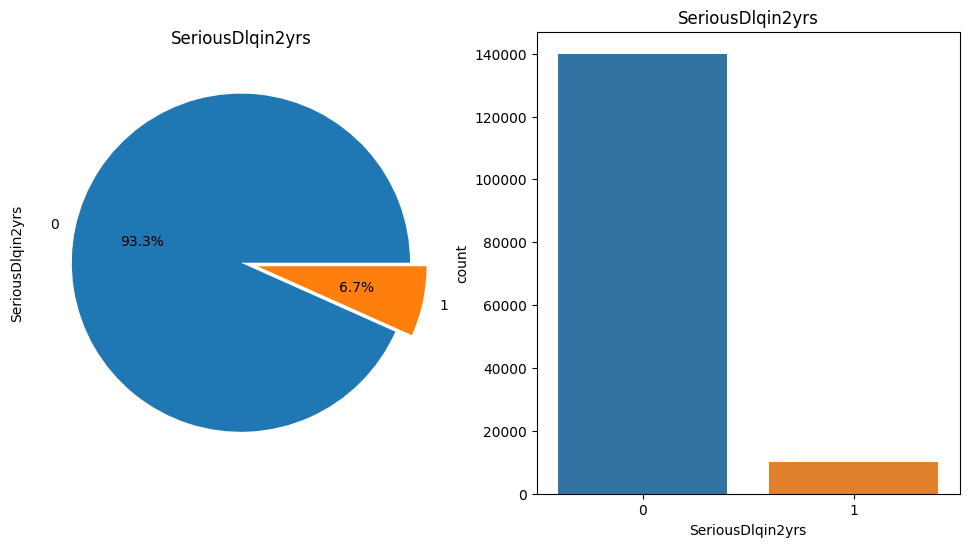

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
df['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')
sns.countplot(x='SeriousDlqin2yrs',data=df,ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')
plt.show()

In [13]:
df['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [14]:
df.describe()

CustomerID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std        14.771866                              4.192781    2037.818523   
min         0.000000                              0.000000       0.000000   
25%        41.000000                              0.000000       0.175074   
50%        52.000000                              0.000000       0.366508   
75%        63.000000                              0.000000       0.868254   
max       109.000000                             98.000000  329664.000000   

       MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
count   1.202690e+05                    150000.000000   
mean    6.670221e+03                         8.452760   
std     1.438467e+04                         5.145951   
min     0.000000e+00                         0.000000   
25%     3.400000e+03                         5.000000   
50%     5.400000e+03                         8.000000   
75%     8.249000e+03                        11.000000   
max     3.008750e+06                        58.000000   

       NumberOfTimes90DaysLate  NumberRealEstateLoansOrLines  \
count            150000.000000                 150000.000000   
mean                  0.265973                      1.018240   
std                   4.169304                      1.129771   
min                   0.000000                      0.000000   
25%                   0.000000                      0.000000   
50%                   0.000000                      1.000000   
75%                   0.000000                      2.000000   
max                  98.000000                     54.000000   

       NumberOfTime60-89DaysPastDueNotWorse  NumberOfDependents  
count                         150000.000000       146076.000000  
mean                               0.240387            0.757222  
std                                4.155179            1.115086  
min                                0.000000            0.000000  
25%                                0.000000            0.000000  
50%                                0.000000            0.000000  
75%                                0.000000            1.000000  
max                               98.000000           20.000000

### Separating the dataset into train-test split

* **We will split the dataset into training(80%) on which modeling will be done using statistical/machine learning technqiues**
* **
* **Another one is the test dataset(20%) on which predictions will be made and check how the model is performing**

In [15]:
data = df.drop(columns = ['SeriousDlqin2yrs'], axis=1)

In [16]:
y = df['SeriousDlqin2yrs']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Splitting the dataset into train and test validation
df_test, df_train, y_test, y_train = train_test_split(data, y, test_size = 0.8, random_state=42, stratify = y)
df_test.shape, df_train.shape

((30000, 11), (120000, 11))

In [19]:
print('Event rate in the training dataset : ',np.mean(y_train))
print()
print('Event rate in the test dataset : ',np.mean(y_test))
print()
print('Event rate in the entire dataset : ',np.mean(y))

Event rate in the training dataset :  0.06684166666666666

Event rate in the test dataset :  0.06683333333333333

Event rate in the entire dataset :  0.06684


* Event rate/Default Rate is maintainted in the training and test dataset after splitting in line with the entire dataset

In [20]:
train = pd.concat([df_train, y_train], axis=1)
train.shape

(120000, 12)

In [21]:
test = pd.concat([df_test, y_test], axis=1)
test.shape

(30000, 12)

### Univariate Analysis using Training Numerical dataset

In [22]:
def plot_hist_boxplot(column):
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
    sns.distplot(train[train[column].notnull()][column],ax=ax1)
    sns.boxplot(y=train[train[column].notnull()][column],ax=ax2)
    print("skewness : ",skew(train[train[column].notnull()][column]))
    print("kurtosis : ",kurtosis(train[train[column].notnull()][column]))
    plt.show()

In [23]:
def plot_count_boxplot(column):
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,6))
    sns.countplot(train[train[column].notnull()][column],ax=ax1)
    sns.boxplot(y=train[train[column].notnull()][column],ax=ax2)
    print("skewness : ",skew(train[train[column].notnull()][column]))
    print("kurtosis : ",kurtosis(train[train[column].notnull()][column]))
    plt.show()

skewness :  104.51383625945637
kurtosis :  16544.639125909292


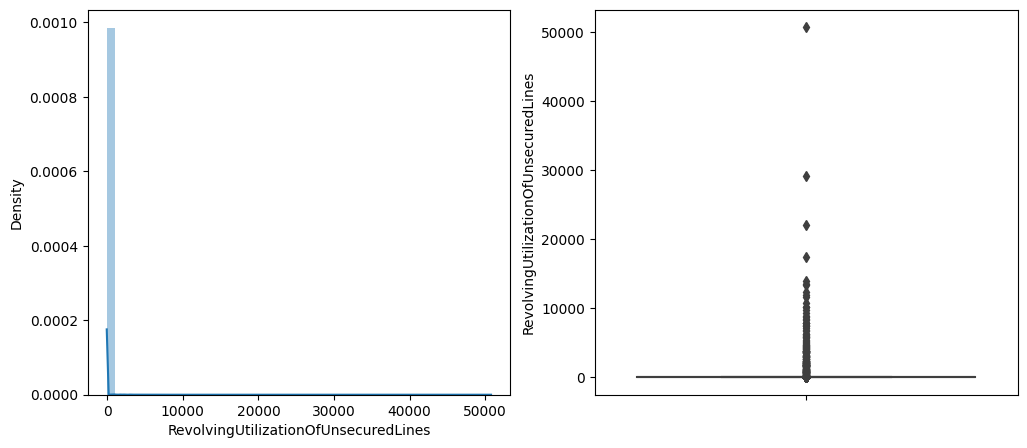

In [24]:
plot_hist_boxplot('RevolvingUtilizationOfUnsecuredLines')

skewness :  0.1883379862757487
kurtosis :  -0.4989842553901078


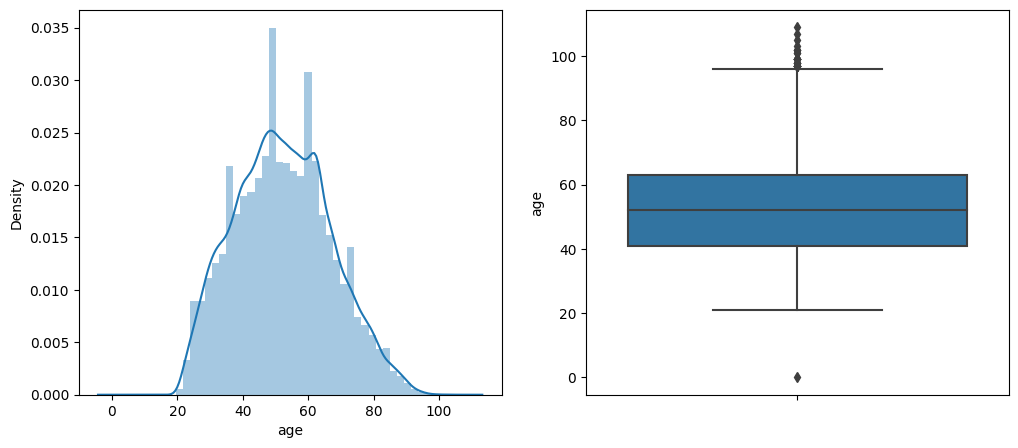

In [25]:
plot_hist_boxplot('age')

skewness :  95.78845308753385
kurtosis :  14212.893907176613


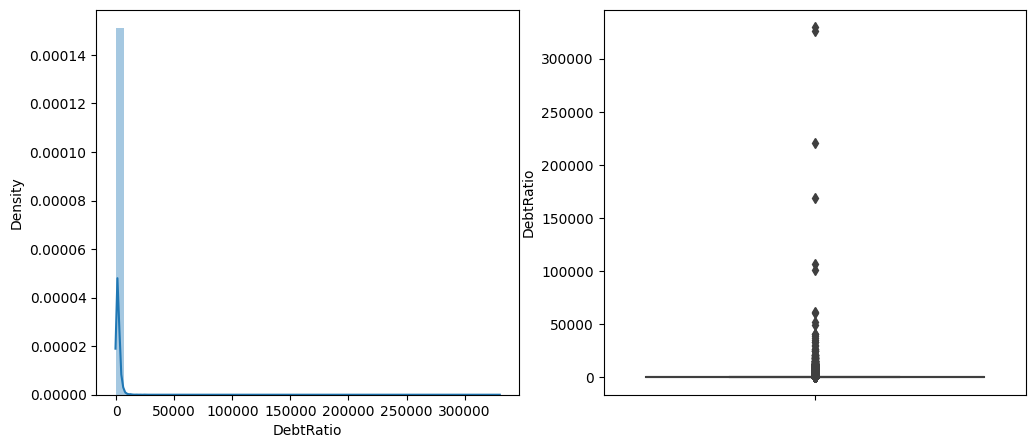

In [26]:
plot_hist_boxplot('DebtRatio')

skewness :  117.98020100894865
kurtosis :  19658.712451467025


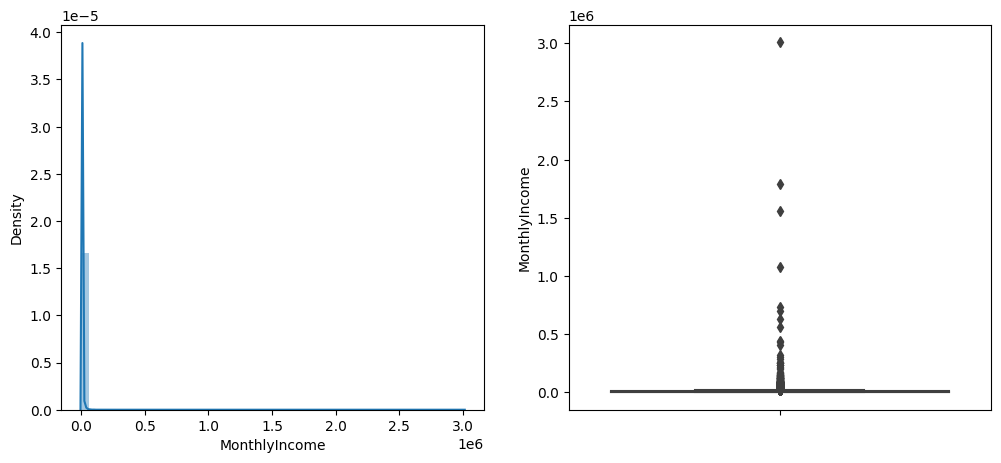

In [27]:
plot_hist_boxplot('MonthlyIncome')

skewness :  1.2145901173605567
kurtosis :  3.114685912968633


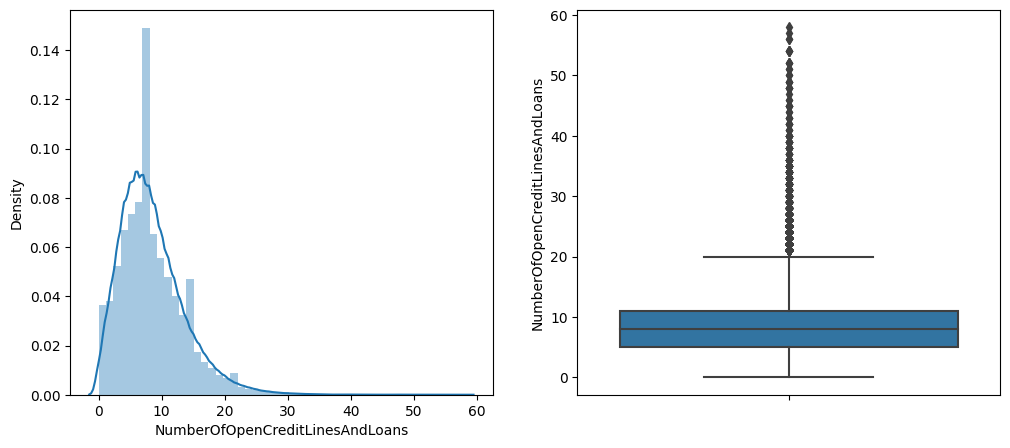

In [28]:
plot_hist_boxplot('NumberOfOpenCreditLinesAndLoans')

skewness :  3.635466187390173
kurtosis :  67.79380246787325


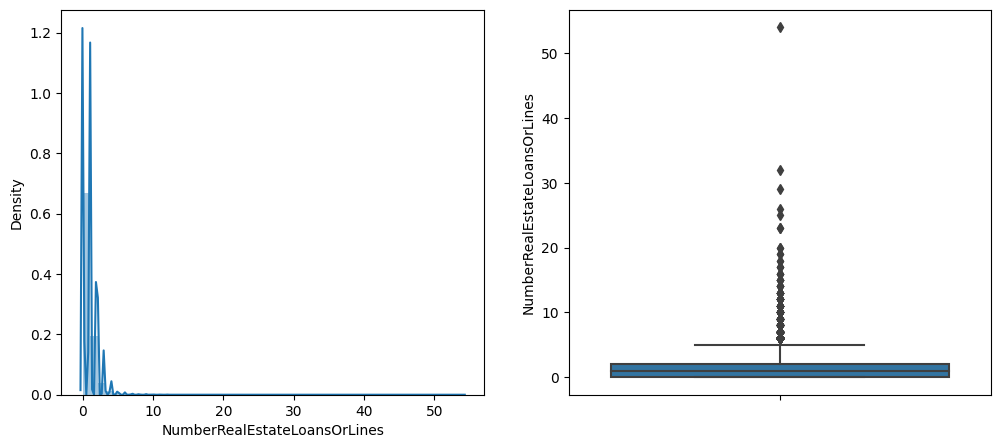

In [29]:
plot_hist_boxplot('NumberRealEstateLoansOrLines')

skewness :  1.5991497659767622
kurtosis :  3.1681417562669285


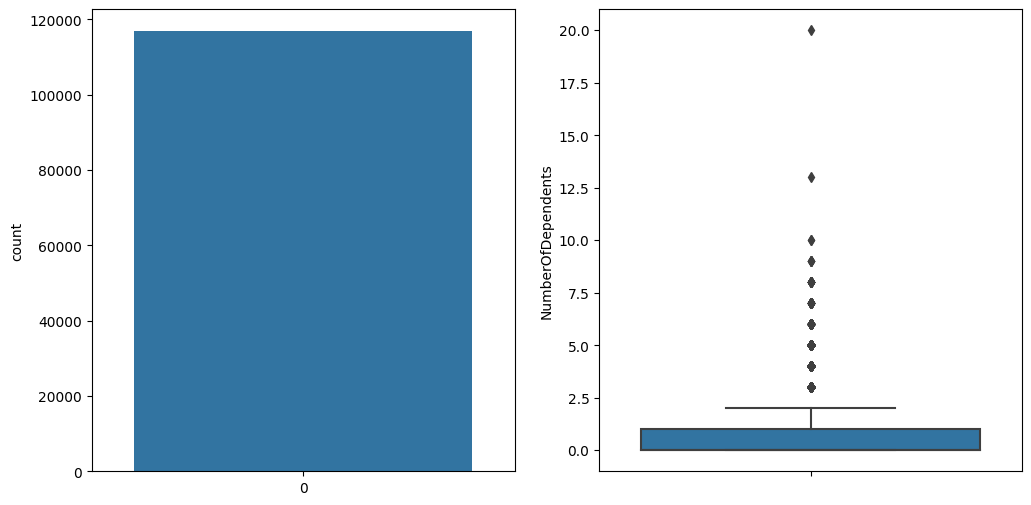

In [30]:
plot_count_boxplot('NumberOfDependents')

skewness :  22.56005009391927
kurtosis :  520.5861400129826


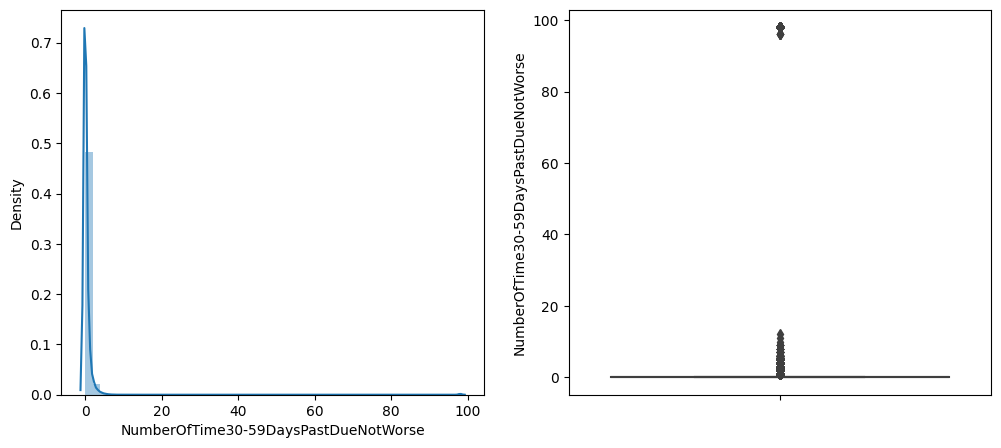

In [31]:
plot_hist_boxplot('NumberOfTime30-59DaysPastDueNotWorse')

skewness :  23.287569502079286
kurtosis :  543.6121286456557


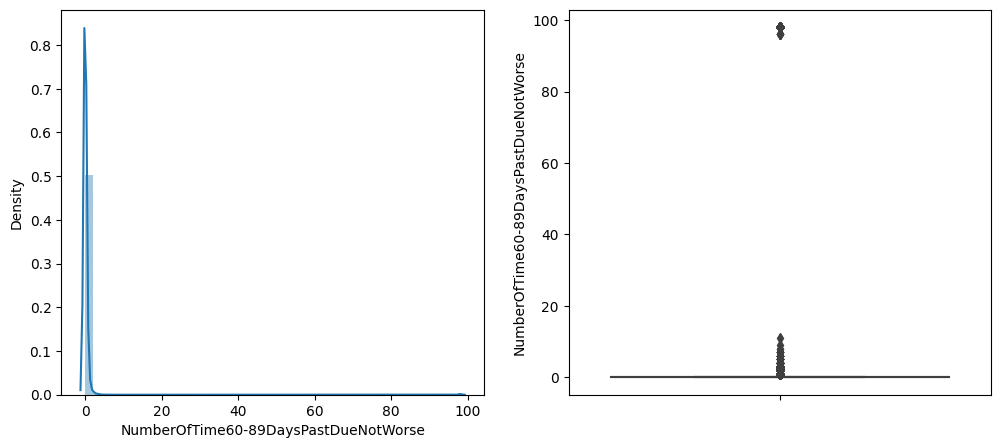

In [32]:
plot_hist_boxplot('NumberOfTime60-89DaysPastDueNotWorse')

skewness :  23.0371547196054
kurtosis :  535.4918343524778


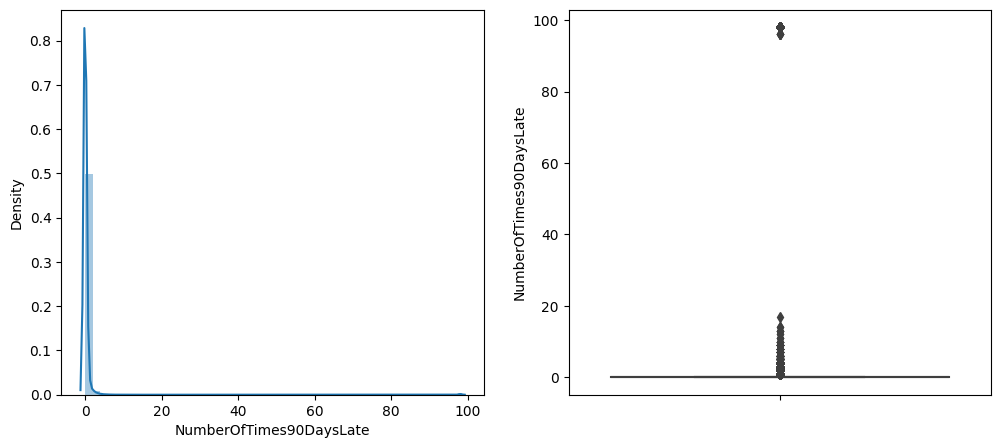

In [33]:
plot_hist_boxplot('NumberOfTimes90DaysLate')

In [34]:
cols_for_stats = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [35]:
skewness  = [] ; kurt = []
for column in cols_for_stats:
    skewness.append(skew(train[train[column].notnull()][column]))
    kurt.append(kurtosis(train[train[column].notnull()][column]))
    
stats = pd.DataFrame({'Skewness' : skewness, 'Kurtosis' : kurt},index=[col for col in cols_for_stats])
stats.sort_values(by=['Skewness'], ascending=False)

Skewness      Kurtosis
MonthlyIncome                         117.980201  19658.712451
RevolvingUtilizationOfUnsecuredLines  104.513836  16544.639126
DebtRatio                              95.788453  14212.893907
NumberOfTime60-89DaysPastDueNotWorse   23.287570    543.612129
NumberOfTimes90DaysLate                23.037155    535.491834
NumberOfTime30-59DaysPastDueNotWorse   22.560050    520.586140
NumberRealEstateLoansOrLines            3.635466     67.793802
NumberOfDependents                      1.599150      3.168142
NumberOfOpenCreditLinesAndLoans         1.214590      3.114686
age                                     0.188338     -0.498984

* * Data distribution in the columns are highly right skewed with very high kurtosis value showing extreme outliers in those columns
* * Except age which is little normally distributed

### Data Cleaning

#### Outlier Treatement

* *From the above boxplot graphs we can observe:*
* **
* *In the columns NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate, we see delinquency range beyond 90 which is common across all 3 features.*
* **
* *Treating outliers for the columns  -- NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate*

In [36]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))


print("Unique values in '30-59 Days' values that are less than 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(train[train['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))


print("Proportion of positive class with special 96/98 values:",
      round(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs'].sum()*100/
      len(train[train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs']),2),'%')

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]
Proportion of positive class with special 96/98 values: 55.56 %


* *We can see from the following that when records in column 'NumberOfTime30-59DaysPastDueNotWorse' are more than 90, the other columns that records number of times payments are past due X days also have the same values. We will classify these as special labels since the proportion of positive class is abnormally high at 55.56%.*
* **
* *These 96 and 98 values can be viewed as accounting errors. Hence, we would replace them with the maximum value before 96 i.e. 12, 11 and 17*

In [37]:
train.loc[train['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 12
train.loc[train['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
train.loc[train['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

In [38]:
print("Unique values in 30-59Days", np.unique(train['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(train['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(train['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17]


In [39]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))


print("Unique values in '30-59 Days' values that are less than 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))


Unique values in '30-59 Days' values that are more than or equal to 90: [98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [0 1 2 3 4 5 6 7]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 15]


* *Since, these values exist in Test Set as well. Therefore, replacing them with maximum values before 96 and 98 i.e. 13, 7 and 15.*

In [40]:
test.loc[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
test.loc[test['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 7
test.loc[test['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 15
print("Unique values in 30-59Days", np.unique(test['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(test['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(test['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in 60-89Days [0 1 2 3 4 5 6 7]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 15]


 * *Checking for * **DebtRatio** and * **RevolvingUtilizationOfUnsecuredLines.***

In [41]:
print('Debt Ratio: \n',train['DebtRatio'].describe())
print('\nRevolving Utilization of Unsecured Lines: \n',train['RevolvingUtilizationOfUnsecuredLines'].describe())

Debt Ratio: 
 count    120000.000000
mean        350.913763
std        1985.649364
min           0.000000
25%           0.174335
50%           0.365643
75%           0.866853
max      329664.000000
Name: DebtRatio, dtype: float64

Revolving Utilization of Unsecured Lines: 
 count    120000.000000
mean          5.986096
std         251.444207
min           0.000000
25%           0.029737
50%           0.154659
75%           0.559328
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


* **Debt Ratio**

* As you can see data is right skewed. So, our main aim would be to check the potential outliers beyond 95% quantiles. However, since our data is 120,000, let's consider 95% and 97.5% quantiles for our further analysis.

In [42]:
train[train['DebtRatio'] >= train['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

SeriousDlqin2yrs  MonthlyIncome
count       6002.000000     308.000000
mean           0.054315       0.077922
std            0.226658       0.268485
min            0.000000       0.000000
25%            0.000000       0.000000
50%            0.000000       0.000000
75%            0.000000       0.000000
max            1.000000       1.000000

* Here we can observe:
* **
* Out of 6002 customers falling in the last 5 percentile of the data i.e. the number of times their debt is higher than their income, only 308 have Monthly Income values.
* The Max for Monthly Income is 1 and Min is 0 which makes us wonder that are data entry errors. Let's check whether the Serious Delinquency in 2 years and Monthly Income values are equal.

In [43]:
train[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome'])].shape[0]

271

* Hence, our suspects are true and there are 271 out of 308 rows where Monthly Income is equal to the Serious Delinquencies in 2 years. Hence we will remove these 271 outliers from our analysis as their current values aren't useful for our predictive modelling and will add to the bias and variance.

In [44]:
new_train = train[-((train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome']))]
new_train.shape

(119729, 12)

* **Revolving Utilization of Unsecured Lines**

* This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let's see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [45]:
new_train[new_train['RevolvingUtilizationOfUnsecuredLines']>10].describe()

CustomerID  RevolvingUtilizationOfUnsecuredLines         age  \
count     187.000000                            187.000000  187.000000   
mean    78422.989305                           3634.411136   50.989305   
std     40921.820372                           5247.138619   14.651136   
min       294.000000                             14.000000   24.000000   
25%     44759.500000                            953.000000   39.000000   
50%     80200.000000                           2120.000000   49.000000   
75%    113817.000000                           4240.000000   63.000000   
max    149161.000000                          50708.000000   87.000000   

       NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
count                            187.000000   187.000000     133.000000   
mean                               0.176471   522.932048    9020.067669   
std                                0.544654  1205.632700    7156.622316   
min                                0.000000     0.000800       0.000000   
25%                                0.000000     0.217823    5000.000000   
50%                                0.000000     0.381491    7083.000000   
75%                                0.000000    90.000000   10575.000000   
max                                3.000000  6820.000000   44472.000000   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                       187.000000               187.000000   
mean                          5.614973                 0.080214   
std                           3.100709                 0.646732   
min                           1.000000                 0.000000   
25%                           4.000000                 0.000000   
50%                           5.000000                 0.000000   
75%                           7.000000                 0.000000   
max                          21.000000                 8.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                    187.000000                            187.000000   
mean                       1.208556                              0.080214   
std                        1.094626                              0.603737   
min                        0.000000                              0.000000   
25%                        1.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                        9.000000                              7.000000   

       NumberOfDependents  SeriousDlqin2yrs  
count          179.000000        187.000000  
mean             0.687151          0.048128  
std              1.045269          0.214612  
min              0.000000          0.000000  
25%              0.000000          0.000000  
50%              0.000000          0.000000  
75%              1.000000          0.000000  
max              4.000000          1.000000

* Despite owing thousands, out of these these 187 people ,less than 10 people are falling in the serious delinquency which means this might be another error. Even if it is not an error, these numbers will add huge bias and variance to our final predictions. Therefore, the best decision is to remove these values.

In [46]:
new_train = new_train[new_train['RevolvingUtilizationOfUnsecuredLines']<=10]
new_train.shape

(119542, 12)

In [47]:
new_test = test[test['RevolvingUtilizationOfUnsecuredLines']<=10]
new_test.shape

(29946, 12)

* **Age**

In [48]:
new_train[['age', 'SeriousDlqin2yrs']].describe()

age  SeriousDlqin2yrs
count  119542.000000     119542.000000
mean       52.296130          0.067006
std        14.775558          0.250033
min         0.000000          0.000000
25%        41.000000          0.000000
50%        52.000000          0.000000
75%        63.000000          0.000000
max       109.000000          1.000000

* It can be observed that the data includes a record with age = 0 which is not a valid age ,updating the record with mode age.

In [49]:
new_train[new_train['age']<1]

CustomerID  RevolvingUtilizationOfUnsecuredLines  age  \
65695       65696                                   1.0    0   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
65695                                     1   0.436927         6000.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
65695                                6                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
65695                             2                                     0   

       NumberOfDependents  SeriousDlqin2yrs  
65695                 2.0                 0

* We will be replacing the error/odd value with the mode

In [50]:
new_train.loc[new_train['age'] == 0, 'age'] = new_train.age.mode()[0]

In [51]:
new_train['age'].min()

21

In [52]:
new_test[new_test['age']<1]

Empty DataFrame
Columns: [CustomerID, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents, SeriousDlqin2yrs]
Index: []

* No such discrepancy is found in the test dataset

#### Missing Value Treatment

* *Since MonthlyIncome is an integer value, we will replace the nulls with the median values instead of mean as it was heavily right skewed.*
* **
* *Number of Dependents can be characterized as a categorical variable, hence if customers have NA for number of dependents, it means that they do not have any dependents. 
Filling either by mode which is 0 or by the above assumption is the same.Therefore, we fill them with zeros.*

In [53]:
def MissingHandler(df):
    
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

#MissingHandler(new_train)

In [54]:
new_train['MonthlyIncome'].fillna(new_train['MonthlyIncome'].median(), inplace=True)
new_train['NumberOfDependents'].fillna(0, inplace = True)

* **Filling missing values with the same logic on the validation and the test dataset**

In [55]:
new_test['MonthlyIncome'].fillna(new_test['MonthlyIncome'].median(), inplace=True)
new_test['NumberOfDependents'].fillna(0, inplace = True)

* ** Rechecking Nulls**

In [56]:
MissingHandler(new_train)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [57]:
MissingHandler(new_test)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [58]:
MissingHandler(df_test)

Percentage Nulls
MonthlyIncome              19.943333
NumberOfDependents          2.643333

* **Correlation Plot**

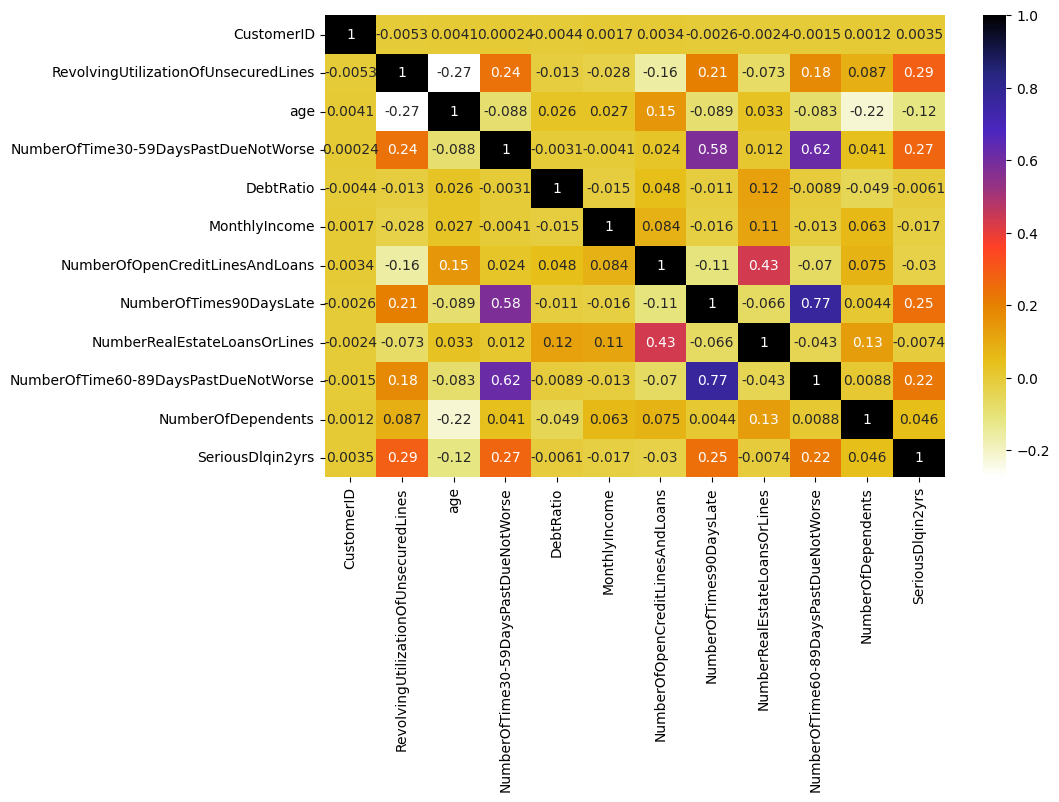

In [59]:
plt.figure(figsize=(10,6))
sns.heatmap(new_train.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

* From the correlation heatmap above, we can see the most correlated values to SeriousDlqin2yrs are NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate.
* **
* Number of Open Credit Lines and Loans and Number of Real Estate Loans or Lines also have a significant correlation

### Bivariate Analysis

In [60]:
def boxplot_violinplot(col1, col2):
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
    sns.boxplot(x=col1, y=col2, data=new_train, palette='Set3',ax=ax1)
    sns.violinplot(x=col1, y=col2, data=new_train, palette='Set3',ax=ax2)
    plt.show()

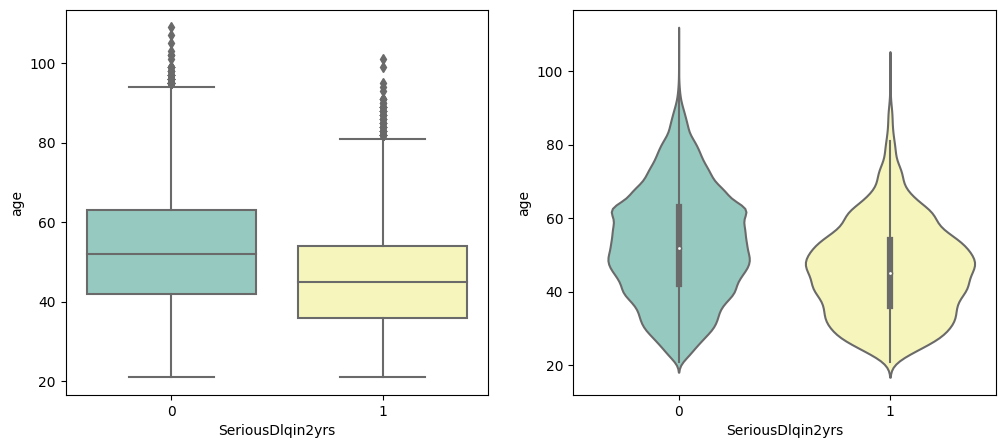

In [61]:
boxplot_violinplot('SeriousDlqin2yrs', 'age')

In [62]:
# Age has no significant on the target variable though most of the customers are in the mid 50 who has serious delinquency in 2 years

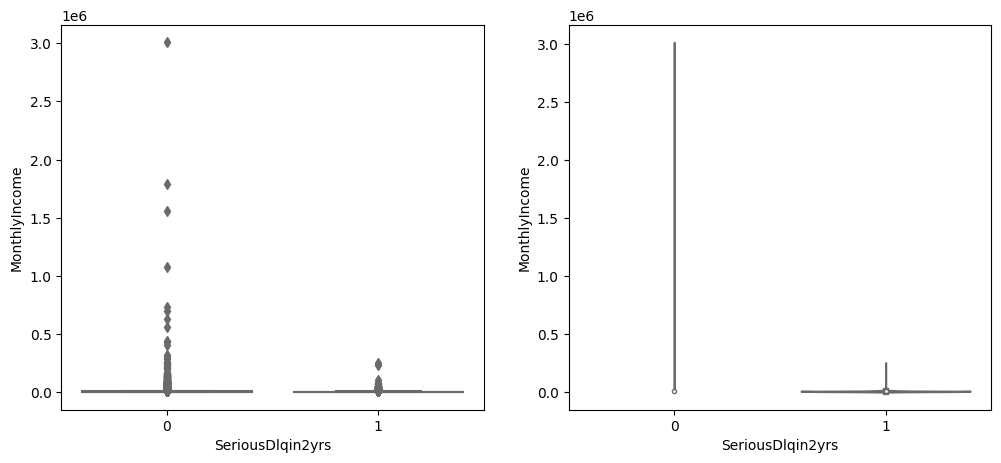

In [63]:
boxplot_violinplot('SeriousDlqin2yrs', 'MonthlyIncome')

In [64]:
# More or less similar relationship when target is 0 or 1

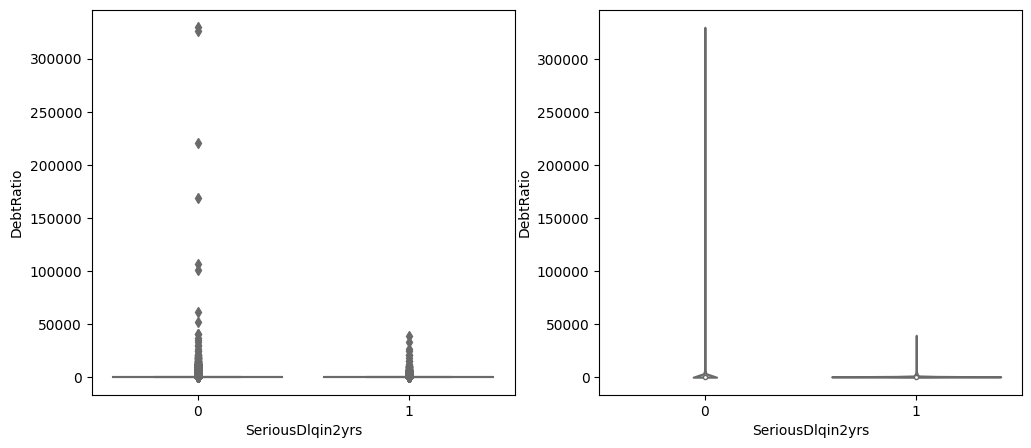

In [65]:
boxplot_violinplot('SeriousDlqin2yrs','DebtRatio')

In [66]:
# More or less similar relationship when target is 0 or 1

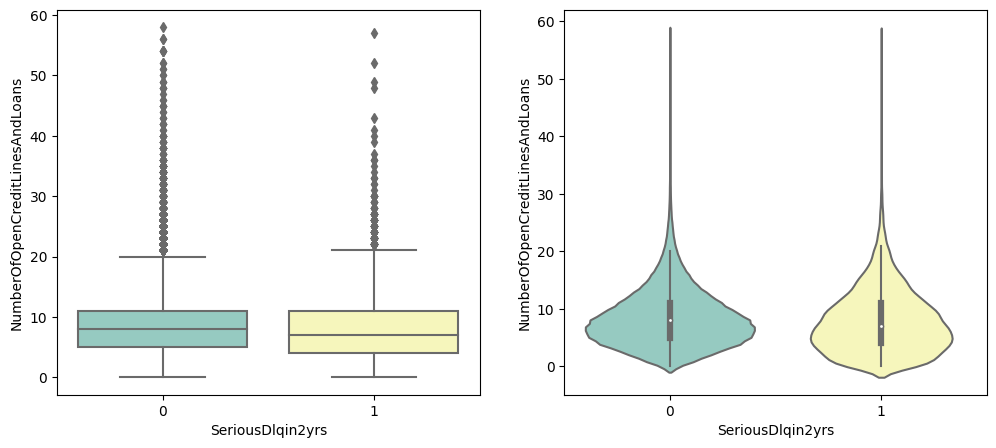

In [67]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfOpenCreditLinesAndLoans')

* It is expected that the higher the utlization ratio, the higher the default rate is. Let me look into that by plotting the utlization ratio to default rate

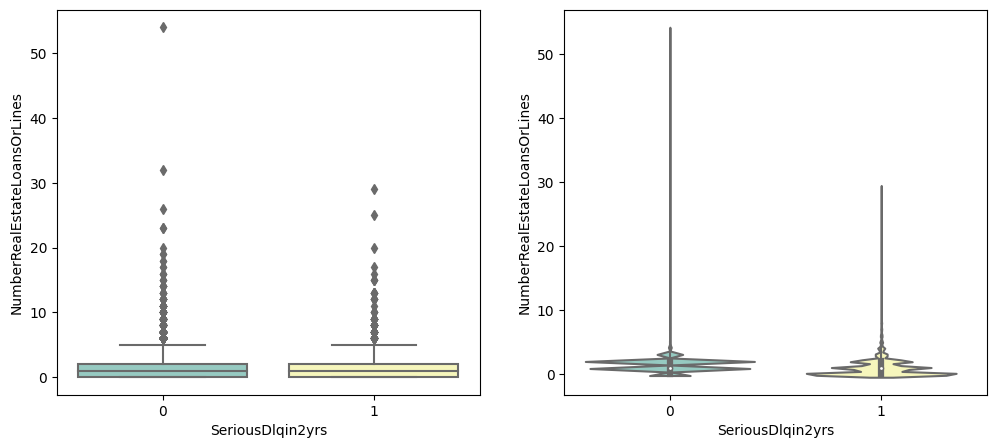

In [68]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberRealEstateLoansOrLines')

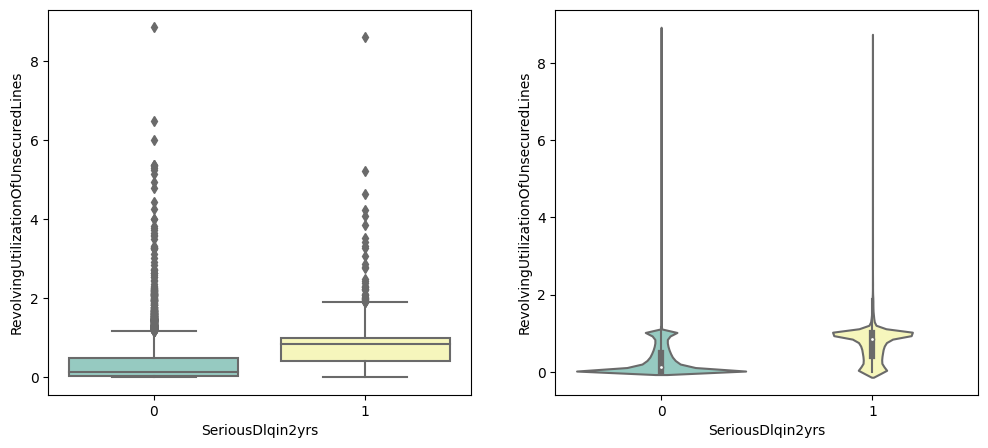

In [69]:
boxplot_violinplot('SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines')

In [70]:
# Feature description itself more the utlization of the credit resources or the ratio of amount owe to credit is more, serious delinquency is on a bit higher side

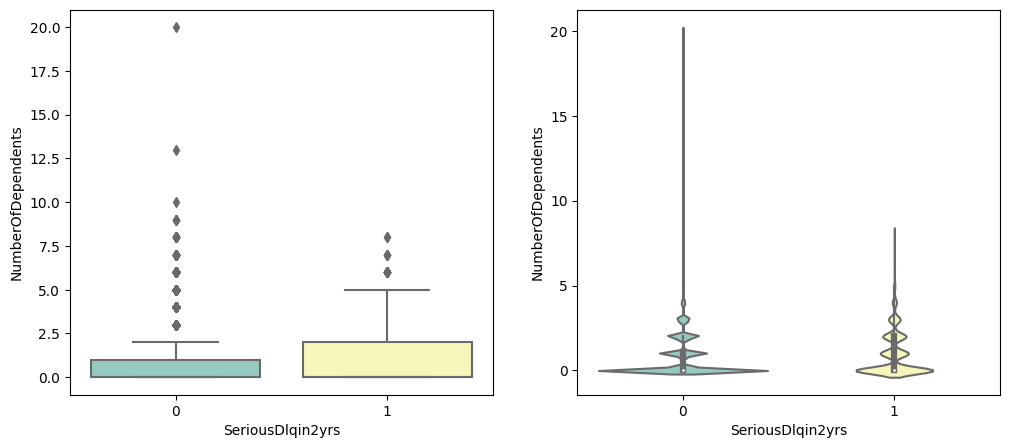

In [71]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfDependents')

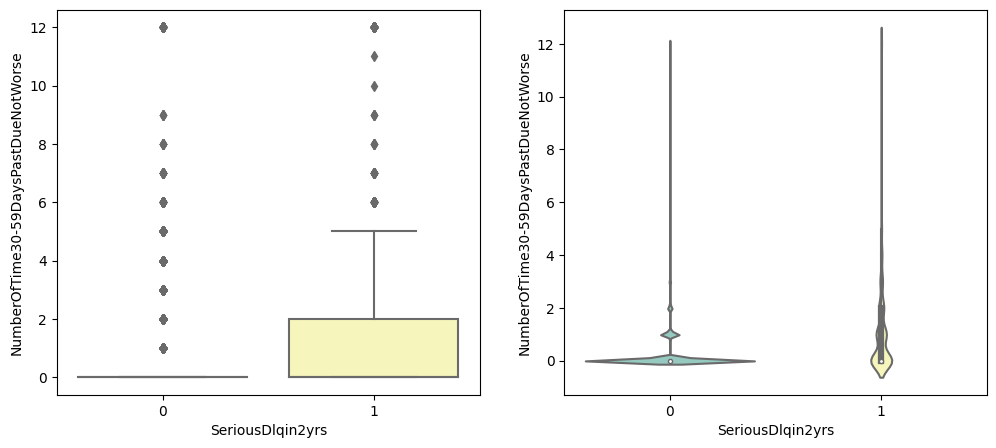

In [72]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse')

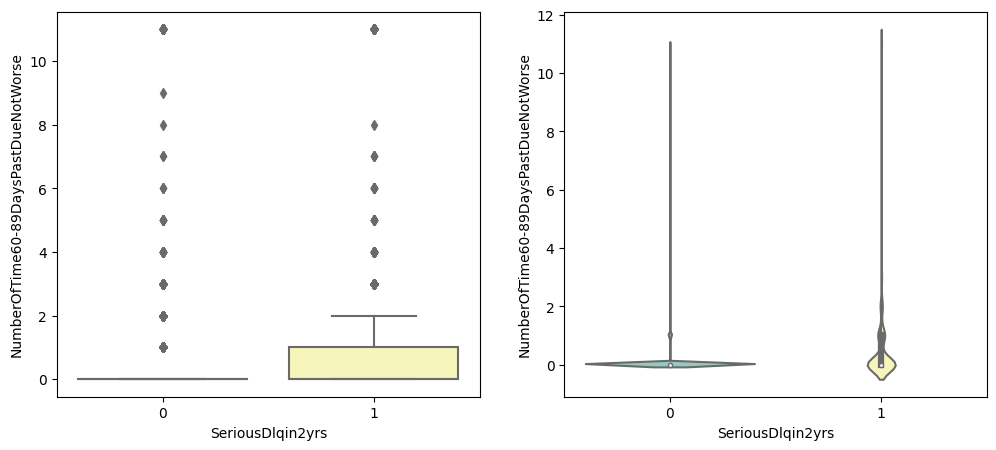

In [73]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime60-89DaysPastDueNotWorse')

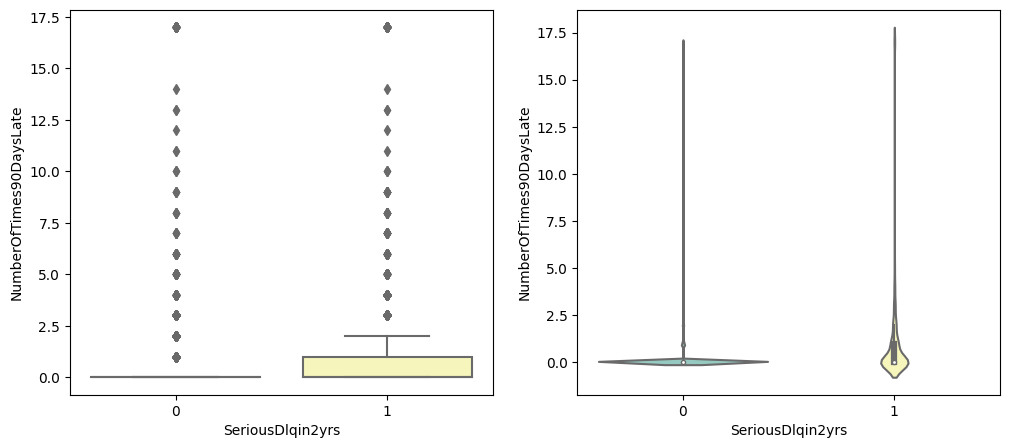

In [74]:
boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTimes90DaysLate')

* It is expected that the higher the utlization ratio, the higher the default rate is. Let me look into that by plotting the utlization ratio to default rate

* **Now let's move to the Feature Engineering section of our Notebook**

### Feature Engineering

In [75]:
dataset = [new_train, new_test]

* Making combined features

In [76]:
for data in dataset:
    
    data['CombinedPastDue']     = data['NumberOfTime30-59DaysPastDueNotWorse'] + data['NumberOfTime60-89DaysPastDueNotWorse'] + data['NumberOfTimes90DaysLate']
    data['CombinedCreditLoans'] = data['NumberOfOpenCreditLinesAndLoans'] + data['NumberRealEstateLoansOrLines']
    
new_train.columns    

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans'],
      dtype='object')

* Interaction of the features

In [77]:
for data in dataset:

    data['MonthlyIncomePerPerson'] = data['MonthlyIncome']/(data['NumberOfDependents']+1)
    
    data['MonthlyDebt']            = data['MonthlyIncome']*data['DebtRatio']
    
    data['isRetired']              = np.where((data['age'] > 65), 1, 0)
    
    data['RevolvingLines']         = data['NumberOfOpenCreditLinesAndLoans']-data['NumberRealEstateLoansOrLines']
    data['hasRevolvingLines']      = np.where((data['RevolvingLines']>0),1,0)
    
    data['hasMultipleRealEstates'] = np.where((data['NumberRealEstateLoansOrLines']>=2),1,0)
    
    data['IsAlone']                = np.where((data['NumberOfDependents']==0),1,0)
    
new_train.columns

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans', 'MonthlyIncomePerPerson', 'MonthlyDebt',
       'isRetired', 'RevolvingLines', 'hasRevolvingLines',
       'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

In [78]:
new_train.shape, new_test.shape

((119542, 21), (29946, 21))

In [79]:
print(new_train['SeriousDlqin2yrs'].sum()/len(new_train))
print()
print(new_test['SeriousDlqin2yrs'].sum()/len(new_test))

0.0670057385688712

0.06668670273158352


* ** Tackling Class Imbalance Problem using:**
* **
    * Upsampling the minority class(default rate)
    * Downsampling the majority class(non defaulters)
    * SMOTE - synthethic sampling

In [80]:
df_train = new_train.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_train = new_train['SeriousDlqin2yrs']

df_test = new_test.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_test = new_test['SeriousDlqin2yrs']

#### Upsampling

In [81]:
df_majority = new_train[new_train['SeriousDlqin2yrs']==0]
df_minority = new_train[new_train['SeriousDlqin2yrs']==1]

In [82]:
# replacing the samples keeping 100000 as the defaulters to keep in line with the non defaulters
df_minority_upsampled = resample(df_minority, replace=True, n_samples=100000, random_state=42)
df_upsampled = pd.concat([df_majority,df_minority_upsampled])
df_upsampled['SeriousDlqin2yrs'].value_counts()

0    111532
1    100000
Name: SeriousDlqin2yrs, dtype: int64

In [83]:
y_train_upsampled = df_upsampled['SeriousDlqin2yrs']

df_upsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1, inplace=True)

df_upsampled.shape, df_test.shape, y_train_upsampled.shape, y_test.shape

((211532, 19), (29946, 19), (211532,), (29946,))

#### Downsampling

In [84]:
new_train['SeriousDlqin2yrs'].value_counts()

0    111532
1      8010
Name: SeriousDlqin2yrs, dtype: int64

In [85]:
# keeping 8000 as  non defaulters to keep in line with the defaulters
df_majority_downsampled = resample(df_majority, n_samples=8000, random_state=42)
df_downsampled = pd.concat([df_minority,df_majority_downsampled])
df_downsampled['SeriousDlqin2yrs'].value_counts()

1    8010
0    8000
Name: SeriousDlqin2yrs, dtype: int64

In [86]:
y_train_downsampled = df_downsampled['SeriousDlqin2yrs']

df_downsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1, inplace=True)

df_downsampled.shape, df_test.shape, y_train_downsampled.shape, y_test.shape


((16010, 19), (29946, 19), (16010,), (29946,))

#### SMOTE

In [87]:
smote = SMOTE(sampling_strategy = 'minority',k_neighbors = 2,random_state=42)

os_data_X,os_data_y=smote.fit_resample(df_train,y_train)

In [88]:
os_data_X.shape, sum(os_data_y)/len(os_data_y)

((223064, 19), 0.5)

* Now the event rate in the training dataset is 50%

In [89]:
# Making a copy of the dataframes so that tarnsformed df and original df is separate to comapre results

In [90]:
os_data_X_tranformed  = os_data_X.copy()
df_test_transformed   = df_test.copy()

In [91]:
df_test_standaradized = df_test.copy()

In [92]:
df_downsampled_transformed = df_downsampled.copy()
df_upsampled_transformed   = df_upsampled.copy()

* ** Scaling of the features so convergence of the model towards global minima can be achieved and training can be done faster**
* We will be using a couple of Feature Transformation techniques:
* **
    * BoxCox Transformations
    * Standaradization

In [93]:
# We will check with how skewness changes after the transformations and we will check on SMOTE sampling technique dataset

#### Scaling features using BoxCox Transformations

In [94]:
def SkewMeasure(df):
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
    skewM=pd.DataFrame({'skew':skewM})
    return skewM[abs(skewM)>0.5].dropna()

In [95]:
SkewMeasure(os_data_X_tranformed)

skew
MonthlyIncome                         146.968611
MonthlyIncomePerPerson                105.345969
MonthlyDebt                            90.058100
DebtRatio                              87.067428
NumberOfTime60-89DaysPastDueNotWorse    8.583851
NumberOfTimes90DaysLate                 8.078736
CombinedPastDue                         8.062658
NumberOfTime30-59DaysPastDueNotWorse    5.085588
NumberRealEstateLoansOrLines            3.790846
isRetired                               2.563314
NumberOfDependents                      1.428809
hasMultipleRealEstates                  1.355296
RevolvingLines                          1.254642
CombinedCreditLoans                     1.103831
NumberOfOpenCreditLinesAndLoans         1.087161
RevolvingUtilizationOfUnsecuredLines    0.807936
hasRevolvingLines                      -4.240216

In [96]:
skewM = SkewMeasure(os_data_X_tranformed)

for i in skewM.index:
    os_data_X_tranformed[i] = special.boxcox1p(os_data_X_tranformed[i],0.15) #lambda = 0.15
    df_test_transformed[i]  = special.boxcox1p(df_test_transformed[i],0.15) #lambda = 0.15
SkewMeasure(os_data_X_tranformed)

skew
NumberOfTime60-89DaysPastDueNotWorse  4.678528
NumberOfTimes90DaysLate               3.733111
isRetired                             2.563314
NumberOfTime30-59DaysPastDueNotWorse  2.097797
DebtRatio                             2.094686
MonthlyDebt                           1.908265
CombinedPastDue                       1.877250
hasMultipleRealEstates                1.355296
NumberOfDependents                    0.797379
NumberRealEstateLoansOrLines          0.696784
NumberOfOpenCreditLinesAndLoans      -0.563962
CombinedCreditLoans                  -0.605089
MonthlyIncomePerPerson               -1.251531
MonthlyIncome                        -1.944274
hasRevolvingLines                    -4.240216

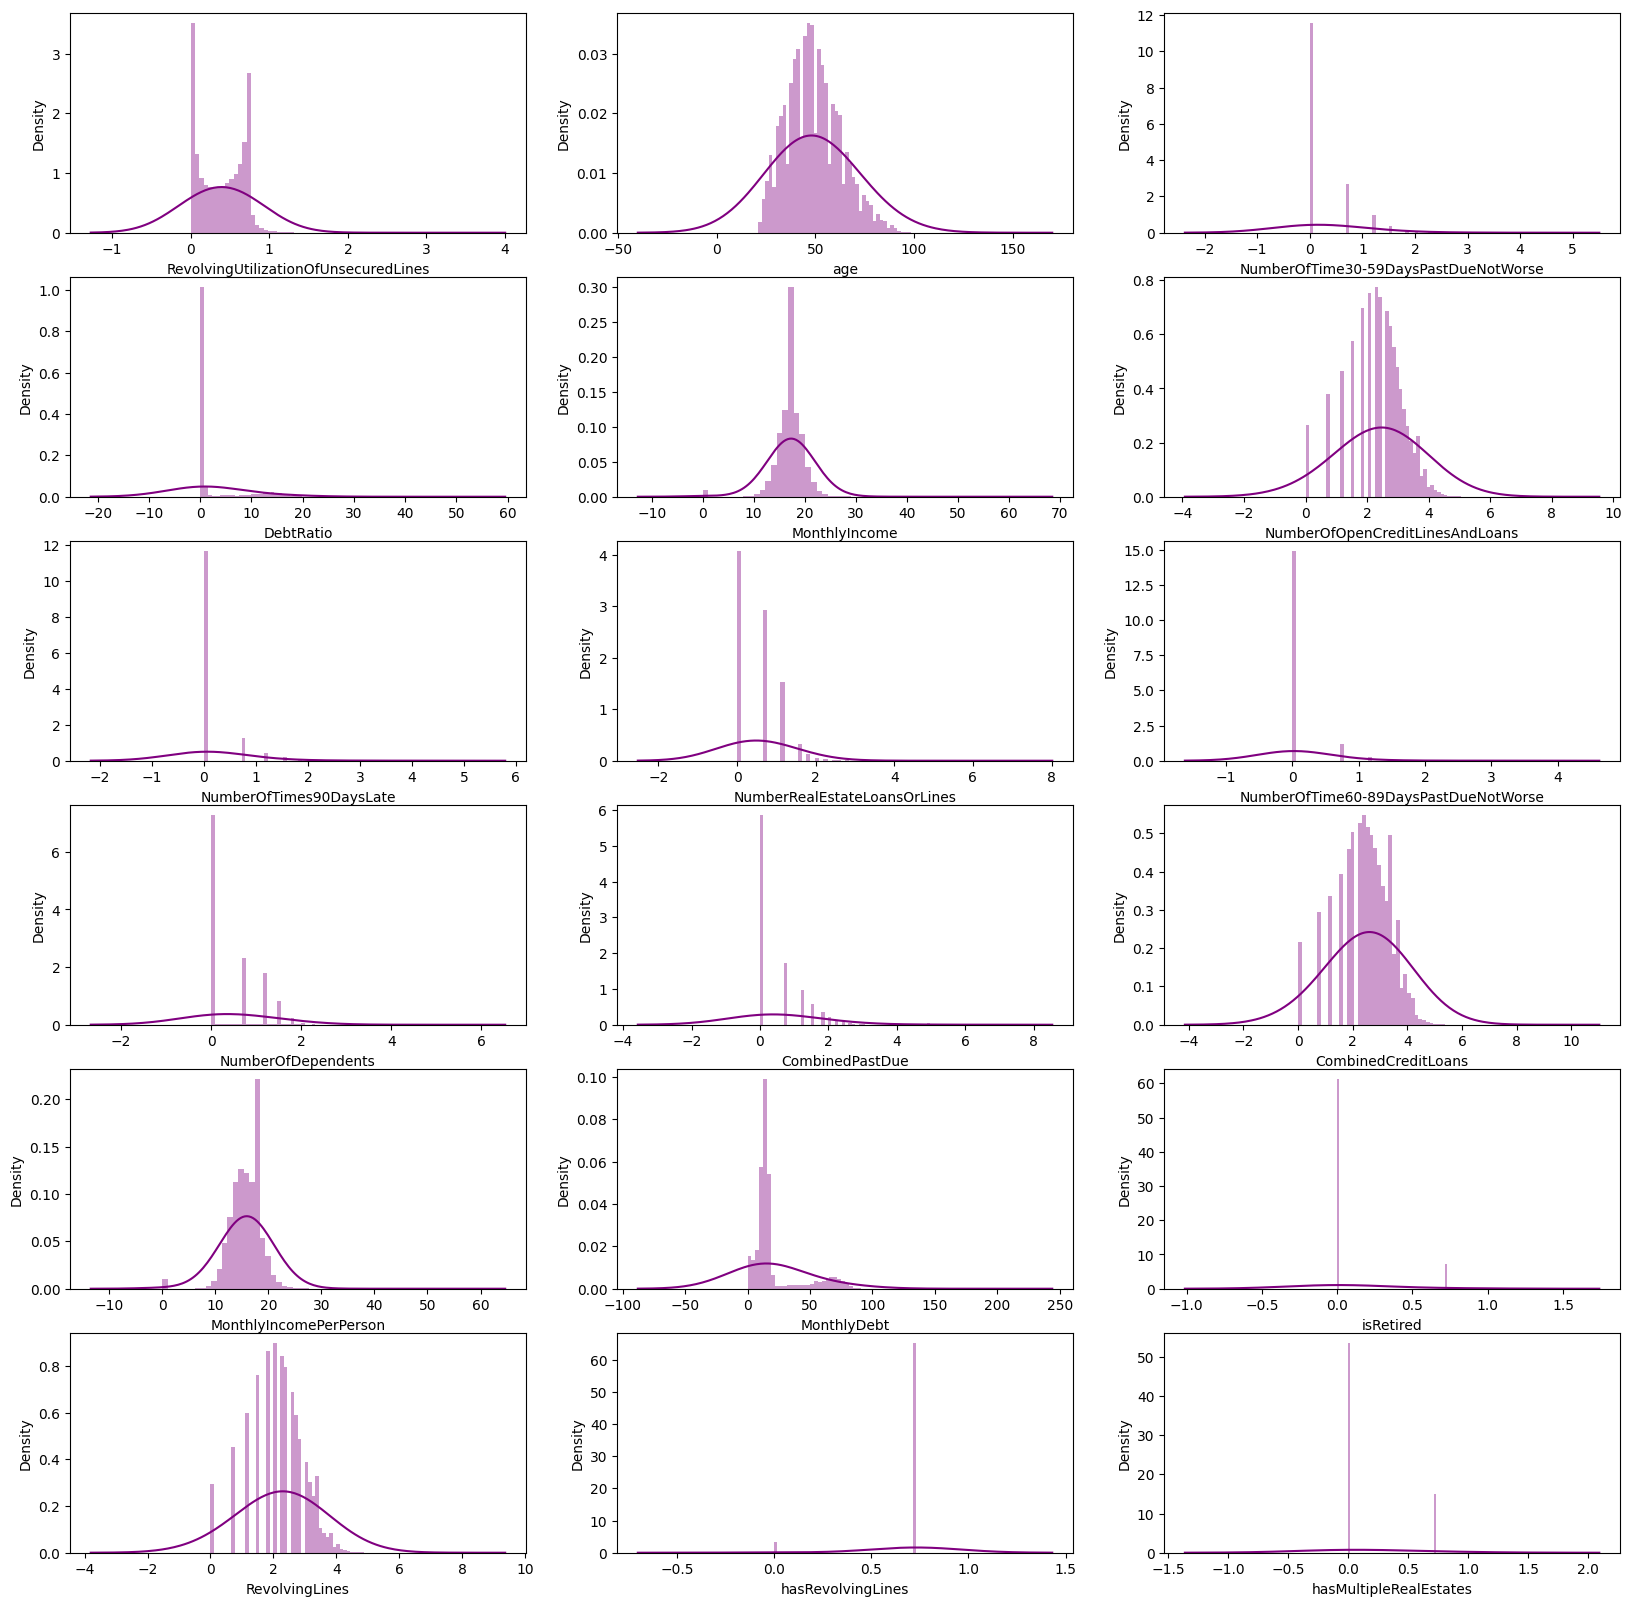

In [97]:
columnList = list(df_test_transformed.columns)

fig = plt.figure(figsize=[20,20])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(os_data_X_tranformed[col],ax=axes, kde_kws={'bw':1.5}, color='purple')
plt.show()

* Skewness is reduced and now the graphs are looking good

In [98]:
df_train_transformed = df_train.copy()

skewM = SkewMeasure(df_train)

for i in skewM.index:
    df_train_transformed[i] = special.boxcox1p(df_train_transformed[i],0.15) #lambda = 0.15

#### Standaradization

In [99]:
scaler = StandardScaler().fit(os_data_X)

X_train_scaled = scaler.transform(os_data_X) 
X_test_scaled = scaler.transform(df_test)

In [100]:
scaler = StandardScaler().fit(df_upsampled_transformed)

X_train_scaled_upsampled = scaler.transform(df_upsampled_transformed) 
X_test_scaled_upsampled = scaler.transform(df_test_standaradized)

In [101]:
scaler = StandardScaler().fit(df_downsampled_transformed)

X_train_scaled_downsampled = scaler.transform(df_downsampled_transformed) 
X_test_scaled_downsampled = scaler.transform(df_test_standaradized)

### Modeling

* ** Training the model :**
    * **
    * We will be training the model using different algorithms 
    * We wil also be comparing the results using transformed dataset and the original dataset
    * We will check and compare on which algorithms transformations works and on which not.
    * We will be doing Cross Validation and will see if the model performance is fluctuating using the statistical measures such as mean and standarad deviation 
* **
* ** Predicting the customers from the test dataset and comapring with the true values from the test dataset using different evaluation metrics will give us which model to go for and which model is performing the best**
* **
* ** We will also be evaluating our model on different metrics and why some metrics might fail in our case study which is one of the most popular metric to evaluate a model performance **
* **
* ** Some common evaluation metric you will be seeing across all modeling algorithms are:**
    * ** Precision** - * How good a model is in predicting the events
        * True Positive/(True Positive + False Positives)
    * ** Recall** - * How good a model is able to capture relevant events(Coverage)
        * True Positive/(True Positive + False Negatives)
    * ** F1 Score** - * Harmonic mean between Precision and Recall, this metric penalized either one of the lower scorer metric so that trade off can be maintained
    * ** Area Under the Curve & ROC** - * how good a model is able to differentiate between the classes
        * It is plotted as False Positive Rate on the x-axis and True Positive Rate on the y-axis  using different thresholds.
        * The more the area or the line it is above straight diagonal line, the better is model performance as comapred to randomly predicting the classes
* **
* ** We will be comapring the different modeling techniques AUC results to see which ones are performing better as compared to others**
* **
* ** We will be tuning hyper parameters of the models to achieve better results and see how tuning increases performance if it does**

### **Supervised Machine Learning**

Supervised learning is a type of machine learning where the algorithm learns from labeled data. In other words, the data used to train the algorithm includes input variables and corresponding output variables. The algorithm learns to predict the output variable based on the input variables. Supervised learning can be further divided into two categories: regression and classification.

* **Regression** is a type of supervised learning where the algorithm learns to predict a continuous output variable. In other words, the output variable is a numerical value. Examples of regression problems include predicting housing prices, stock prices, or the amount of rainfall in a particular area.

* **Classification**, on the other hand, is a type of supervised learning where the algorithm learns to predict a discrete output variable. In other words, the output variable is a category or label. Examples of classification problems include predicting whether an email is spam or not, whether a tumor is malignant or benign, or whether a customer is likely to churn or not.

#### Neural Network

In [102]:
# custom metrics
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [103]:
def fit_model(data, labels, test_data,test_label, epochs, batch_size):
    
    n_inputs = data.shape[1]
    model    = keras.Sequential()
    model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(32,activation = 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1,activation ='sigmoid'))
    
    model_file_name = 'MLP_predict_default_case_study.hdf5'
    ckpt = ModelCheckpoint(model_file_name, monitor='val_precision',
                           save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_recall", mode="max", patience=15)

    model.compile(optimizer = 'adam',
                 loss= 'binary_crossentropy',
                 metrics = [precision,recall])
    
    history = model.fit(data,
                       labels,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[ckpt, early],
                       validation_data=(test_data,test_label))
    
    return model

In [104]:
def compute_precisions_thresolds(data, labels, test_data, test_label, epochs, batch_size):
    trained_model = fit_model(data, labels, test_data, test_label, epochs=epochs, batch_size=batch_size)
    y_test_pred   = trained_model.predict(test_data)
    
    P_macro = [] ; P_micro = [];  R_macro = [] ;R_micro = []; F1_macro = [] ;F1_micro = []; cut_off = [] ; metrics = pd.DataFrame()
    threshold_list = [0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96]
    for thres in threshold_list:
        cut_off.append(thres)
        y_test_pred_new = [1 if el>thres else 0 for el in y_test_pred]
        prec_macro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='macro'),2)
        P_macro.append(prec_macro)
        prec_micro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='micro'),2)
        P_micro.append(prec_micro)
        rec_macro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='macro'),2)
        R_macro.append(rec_macro)
        rec_micro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='micro'),2)
        R_micro.append(rec_micro)
        f1_macro              = round(f1_score(test_label, y_test_pred_new, average='macro'),2)
        F1_macro.append(f1_macro)
        f1_micro              = round(f1_score(test_label, y_test_pred_new, average='micro'),2)
        F1_micro.append(f1_micro)
        
    metrics = pd.DataFrame({'Threshold' : cut_off, 'Precision Macro' : P_macro, 'Precision Micro' : P_micro,'Recall Macro' : R_macro, 'Recall Micro' : R_micro,'F1 Score Macro' : F1_macro, 'F1 Score Micro' : F1_micro})
    return metrics.sort_values(by=['Threshold'], ascending=False)

* ** Appling Neural Network model on Box Cox transformed dataset**

In [105]:
box_cox_metrics = compute_precisions_thresolds(os_data_X_tranformed, os_data_y, df_test_transformed, y_test,epochs=15, batch_size=128)

Epoch 1/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.7497 - precision: 0.6486 - recall: 0.6600 - val_loss: 0.4757 - val_precision: 0.1964 - val_recall: 0.7176
Epoch 2/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.4874 - precision: 0.7540 - recall: 0.8071 - val_loss: 0.4827 - val_precision: 0.1699 - val_recall: 0.7884
Epoch 3/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.4562 - precision: 0.7672 - recall: 0.8304 - val_loss: 0.4604 - val_precision: 0.1770 - val_recall: 0.7711
Epoch 4/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.4405 - precision: 0.7752 - recall: 0.8308 - val_loss: 0.4328 - val_precision: 0.1928 - val_recall: 0.7243
Epoch 5/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.4333 - precision: 0.7792 - recall: 0.8321 - val_loss: 0.4199 - val_precision: 0.1905 - val_recall: 0.7334
Epoch 6/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.42

In [106]:
box_cox_metrics  

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.68             0.93          0.50          0.93   
8       0.95             0.73             0.93          0.50          0.93   
7       0.90             0.75             0.93          0.51          0.93   
6       0.80             0.71             0.93          0.59          0.93   
5       0.70             0.66             0.91          0.68          0.91   
4       0.60             0.60             0.85          0.73          0.85   
3       0.50             0.58             0.78          0.75          0.78   
2       0.40             0.57             0.72          0.75          0.72   
1       0.30             0.56             0.65          0.74          0.65   
0       0.25             0.56             0.61          0.73          0.61   

   F1 Score Macro  F1 Score Micro  
9            0.49            0.93  
8            0.49            0.93  
7            0.51            0.93  
6            0.62            0.93  
5            0.67            0.91  
4            0.63            0.85  
3            0.59            0.78  
2            0.55            0.72  
1            0.51            0.65  
0            0.48            0.61

* ** Applying Neural Network on Standardized dataset**

In [107]:
standardized_metrics = compute_precisions_thresolds(X_train_scaled, os_data_y, X_test_scaled, y_test,epochs=15, batch_size=128)

Epoch 1/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.4754 - precision: 0.7656 - recall: 0.8130 - val_loss: 0.4436 - val_precision: 0.1840 - val_recall: 0.7385
Epoch 2/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3927 - precision: 0.8082 - recall: 0.8383 - val_loss: 0.3379 - val_precision: 0.2240 - val_recall: 0.6380
Epoch 3/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3503 - precision: 0.8367 - recall: 0.8305 - val_loss: 0.3382 - val_precision: 0.2325 - val_recall: 0.5957
Epoch 4/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3372 - precision: 0.8437 - recall: 0.8302 - val_loss: 0.3305 - val_precision: 0.2310 - val_recall: 0.6036
Epoch 5/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3326 - precision: 0.8461 - recall: 0.8309 - val_loss: 0.3288 - val_precision: 0.2326 - val_recall: 0.6172
Epoch 6/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.32

In [108]:
standardized_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.73             0.93          0.50          0.93   
8       0.95             0.72             0.93          0.51          0.93   
7       0.90             0.73             0.93          0.51          0.93   
6       0.80             0.74             0.93          0.54          0.93   
5       0.70             0.67             0.92          0.64          0.92   
4       0.60             0.62             0.88          0.70          0.88   
3       0.50             0.60             0.83          0.74          0.83   
2       0.40             0.58             0.78          0.75          0.78   
1       0.30             0.57             0.72          0.75          0.72   
0       0.25             0.56             0.67          0.74          0.67   

   F1 Score Macro  F1 Score Micro  
9            0.49            0.93  
8            0.50            0.93  
7            0.50            0.93  
6            0.56            0.93  
5            0.65            0.92  
4            0.65            0.88  
3            0.62            0.83  
2            0.59            0.78  
1            0.55            0.72  
0            0.52            0.67

* ** Applying Neural Network on Original Standaradized dataset**

In [109]:
scaler = StandardScaler().fit(df_train)

df_train_scaled = scaler.transform(df_train) 
df_test_scaled = scaler.transform(df_test)

In [110]:
base_metrics = compute_precisions_thresolds(df_train_scaled, y_train, df_test_scaled, y_test, epochs=10, batch_size=128)

Epoch 1/10
934/934 [==============================] - 6s 5ms/step - loss: 0.2246 - precision: 0.3444 - recall: 0.0676 - val_loss: 0.1866 - val_precision: 0.1731 - val_recall: 0.0261
Epoch 2/10
934/934 [==============================] - 5s 5ms/step - loss: 0.1905 - precision: 0.3228 - recall: 0.0539 - val_loss: 0.1852 - val_precision: 0.2080 - val_recall: 0.0316
Epoch 3/10
934/934 [==============================] - 2s 3ms/step - loss: 0.1868 - precision: 0.3390 - recall: 0.0550 - val_loss: 0.1851 - val_precision: 0.3551 - val_recall: 0.0687
Epoch 4/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1860 - precision: 0.2908 - recall: 0.0472 - val_loss: 0.1846 - val_precision: 0.2026 - val_recall: 0.0355
Epoch 5/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1848 - precision: 0.3535 - recall: 0.0645 - val_loss: 0.1846 - val_precision: 0.2225 - val_recall: 0.0382
Epoch 6/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1840 - precisi

In [111]:
base_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93          0.50          0.93   
8       0.95             0.47             0.93          0.50          0.93   
7       0.90             0.47             0.93          0.50          0.93   
6       0.80             0.47             0.93          0.50          0.93   
5       0.70             0.67             0.93          0.50          0.93   
4       0.60             0.77             0.93          0.51          0.93   
3       0.50             0.77             0.94          0.56          0.94   
2       0.40             0.73             0.93          0.63          0.93   
1       0.30             0.70             0.93          0.67          0.93   
0       0.25             0.68             0.92          0.69          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.49            0.93  
4            0.51            0.93  
3            0.58            0.94  
2            0.66            0.93  
1            0.68            0.93  
0            0.69            0.92

* **Applying Neural Network on Upsampled dataset**

In [112]:
upsampled_metrics = compute_precisions_thresolds(X_train_scaled_upsampled, y_train_upsampled, X_test_scaled_upsampled, y_test, epochs=10, batch_size=128)

Epoch 1/10
1653/1653 [==============================] - 4s 2ms/step - loss: 0.5063 - precision: 0.7627 - recall: 0.7275 - val_loss: 0.4442 - val_precision: 0.2124 - val_recall: 0.7301
Epoch 2/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4749 - precision: 0.7787 - recall: 0.7520 - val_loss: 0.4624 - val_precision: 0.2085 - val_recall: 0.7460
Epoch 3/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4703 - precision: 0.7790 - recall: 0.7568 - val_loss: 0.4777 - val_precision: 0.2012 - val_recall: 0.7734
Epoch 4/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4682 - precision: 0.7781 - recall: 0.7604 - val_loss: 0.5045 - val_precision: 0.1900 - val_recall: 0.7877
Epoch 5/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4668 - precision: 0.7771 - recall: 0.7649 - val_loss: 0.4624 - val_precision: 0.2054 - val_recall: 0.7513
Epoch 6/10
1653/1653 [==============================] - 7s 4ms/step - loss: 0.46

In [113]:
upsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.79             0.93          0.52          0.93   
8       0.95             0.80             0.94          0.53          0.94   
7       0.90             0.75             0.94          0.59          0.94   
6       0.80             0.67             0.91          0.71          0.91   
5       0.70             0.65             0.90          0.73          0.90   
4       0.60             0.62             0.86          0.75          0.86   
3       0.50             0.59             0.77          0.77          0.77   
2       0.40             0.57             0.67          0.76          0.67   
1       0.30             0.56             0.56          0.73          0.56   
0       0.25             0.55             0.48          0.69          0.48   

   F1 Score Macro  F1 Score Micro  
9            0.51            0.93  
8            0.53            0.94  
7            0.63            0.94  
6            0.68            0.91  
5            0.68            0.90  
4            0.65            0.86  
3            0.58            0.77  
2            0.52            0.67  
1            0.46            0.56  
0            0.41            0.48

* **Applying Neural Network on Downsampled dataset**

In [114]:
downsampled_metrics = compute_precisions_thresolds(X_train_scaled_downsampled, y_train_downsampled, X_test_scaled_downsampled, y_test, epochs=10, batch_size=128)

Epoch 1/10
126/126 [==============================] - 1s 4ms/step - loss: 0.6534 - precision: 0.6023 - recall: 0.7096 - val_loss: 0.5817 - val_precision: 0.1880 - val_recall: 0.6687
Epoch 2/10
126/126 [==============================] - 1s 4ms/step - loss: 0.5559 - precision: 0.7624 - recall: 0.6910 - val_loss: 0.4960 - val_precision: 0.2155 - val_recall: 0.6639
Epoch 3/10
126/126 [==============================] - 0s 3ms/step - loss: 0.5333 - precision: 0.7826 - recall: 0.7035 - val_loss: 0.4859 - val_precision: 0.2052 - val_recall: 0.7034
Epoch 4/10
126/126 [==============================] - 0s 3ms/step - loss: 0.5127 - precision: 0.7786 - recall: 0.7399 - val_loss: 0.4712 - val_precision: 0.2031 - val_recall: 0.7169
Epoch 5/10
126/126 [==============================] - 0s 4ms/step - loss: 0.5082 - precision: 0.7769 - recall: 0.7571 - val_loss: 0.4713 - val_precision: 0.1990 - val_recall: 0.7336
Epoch 6/10
126/126 [==============================] - 0s 3ms/step - loss: 0.4985 - precisi

In [115]:
downsampled_metrics

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.76             0.93          0.53          0.93   
8       0.95             0.76             0.93          0.53          0.93   
7       0.90             0.74             0.93          0.58          0.93   
6       0.80             0.68             0.92          0.67          0.92   
5       0.70             0.64             0.89          0.73          0.89   
4       0.60             0.61             0.83          0.76          0.83   
3       0.50             0.59             0.78          0.77          0.78   
2       0.40             0.58             0.73          0.77          0.73   
1       0.30             0.56             0.65          0.75          0.65   
0       0.25             0.56             0.58          0.73          0.58   

   F1 Score Macro  F1 Score Micro  
9            0.53            0.93  
8            0.55            0.93  
7            0.62            0.93  
6            0.68            0.92  
5            0.67            0.89  
4            0.63            0.83  
3            0.59            0.78  
2            0.56            0.73  
1            0.51            0.65  
0            0.47            0.58

* It can be cleary seen that Deep learning models require scaling of the features so that error can be minimised when features are nearly of the same scale so that bakcpropogation of errors can be there which results in better optimization
* **
* No effect on Neural Network Models whether samples are downsampled or upsampled but that is not the case when synthetic sampling is used
* **
* Results are more or less the same using Box Cox transformations and Standaradization 

* **Training the model and predicting on unseen dataset:**
    * In total 4 modeling techniques are used - 
        * ** Logistic Regression**
        * ** Random Forest**
        * ** XGBoost**
        * ** Light GBM**
* **
    * Metrics will be calculated using each modeling technique
    * Confusion Matrix numbers are TN, FP, FN, TP
* **
   * **A joint plot of ROC AUC will be made to see the performance of classifiers**

## **Decision Trees**

**Decision Trees in Classification**

Decision trees are a type of supervised learning algorithm that can be used for classification as well as regression problems. They are widely used in machine learning because they are easy to understand and interpret, and can handle both categorical and numerical data. The idea behind decision trees is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

The decision tree starts with a single node, called the root node, which represents the entire dataset. The root node is then split into several child nodes based on the value of a chosen feature. The process of selecting the best feature and splitting the nodes is repeated recursively for each child node until a stopping criterion is reached. This results in a tree-like structure that represents the decision rules learned from the data.

Each node in the decision tree represents a decision or a test of a feature value, and each branch represents the possible outcomes of that decision. The leaves of the tree represent the final decision or the class label assigned to the input data.

**Splitting Criteria**

To build a decision tree, we need a measure that determines how to split the data at each node. The splitting criterion is chosen based on the type of data and the nature of the problem. The most common splitting criteria are:

* Gini index: measures the impurity of a set of labels. It calculates the probability of misclassifying a randomly chosen element from the set, and is used to minimize misclassification errors.
* Information gain: measures the reduction in entropy (uncertainty) after a split. It is used to maximize the information gain in each split.
* Chi-square: measures the difference between observed and expected frequencies of the classes. It is used to minimize the deviation between the observed and expected class distribution.

**Overfitting in Decision Trees**

One of the main challenges in building decision trees is overfitting. Overfitting occurs when the tree is too complex and fits the training data too well, resulting in poor performance on new and unseen data. This can be addressed by pruning the tree or limiting its depth, or by using ensemble methods such as bagging and boosting.

**Ensemble Methods**

Ensemble methods are techniques that combine multiple models to improve performance and reduce overfitting. The two most common ensemble methods used with decision trees are:

* Bagging (Bootstrap Aggregating): involves training multiple decision trees on different subsets of the training data and then combining their predictions by averaging or voting. This reduces the variance and improves the stability of the model.
* Boosting: involves training multiple decision trees sequentially, where each subsequent tree focuses on the misclassified examples of the previous tree. This reduces the bias and improves the accuracy of the model.

Deecision trees are powerful tools for classification problems that provide a clear and interpretable representation of the decision rules learned from the data. The choice of splitting criterion, stopping criterion, and ensemble method can have a significant impact on the performance and generalization of the model.

### **Bagging**



Bagging is an ensemble learning technique that aims to decrease the variance of a single estimator by combining the predictions from multiple learners. The basic idea behind bagging is to generate multiple versions of the training dataset through random sampling with replacement, and then train a separate classifier for each sampled dataset. The predictions from these individual classifiers are then combined using averaging or voting to obtain a final prediction.

**Algorithm:**

Suppose we have a training set D of size n, and we want to train a classifier using bagging. Here are the steps involved:

* Create k different bootstrap samples from D, each of size n.
* Train a classifier on each bootstrap sample.
* When making predictions on a new data point, take the average or majority vote of the predictions from each of the k classifiers.


**Mathematical Explanation:**

Suppose we have a binary classification problem with classes -1 and 1. Let's also assume that we have a training set D of size n, and we want to train a decision tree classifier using bagging.

**Bootstrap Sample**: For each of the k classifiers, we create a bootstrap sample of size n by sampling with replacement from D. This means that each bootstrap sample may contain duplicates of some instances and may also miss some instances from the original dataset. Let's denote the i-th bootstrap sample as D_i.

**Train a Classifier**: We train a decision tree classifier T_i on each bootstrap sample D_i. This gives us k classifiers T_1, T_2, ..., T_k.

**Combine Predictions**: To make a prediction on a new data point x, we take the majority vote of the predictions from each of the k classifiers.

The idea behind bagging is that the variance of the prediction error decreases as k increases. This is because each classifier has a chance to explore a different part of the feature space due to the random sampling with replacement, and the final prediction is a combination of these diverse classifiers.






### **Random Forest**



Random Forest is an ensemble learning algorithm that builds a large number of decision trees and combines them to make a final prediction. It is a type of bagging method, where multiple decision trees are trained on random subsets of the training data and features. The algorithm then averages the predictions of these individual trees to produce a final prediction. Random Forest is particularly useful for handling high-dimensional data and for avoiding overfitting.

**Algorithm of Random Forest**

The algorithm of Random Forest can be summarized in the following steps:

* Start by randomly selecting a subset of the training data, with replacement. This subset is called the bootstrap sample.

* Next, randomly select a subset of features from the full feature set.

* Build a decision tree using the bootstrap sample and the selected subset of features. At each node of the tree, select the best feature and split the data based on the selected feature.

* Repeat steps 1-3 to build multiple trees.

* Finally, combine the predictions of all trees to make a final prediction. For classification, this is usually done by taking a majority vote of the predicted classes. For regression, this is usually done by taking the average of the predicted values.


**Mathematics Behind Random Forest**

The mathematics behind Random Forest involves the use of decision trees and the bootstrap sampling technique. Decision trees are constructed using a recursive binary partitioning algorithm that splits the data based on the values of the selected features. At each node, the algorithm chooses the feature and the split point that maximizes the information gain. Information gain measures the reduction in entropy or impurity of the target variable after the split. The goal is to minimize the impurity of the subsets after each split.

Bootstrap sampling is a statistical technique that involves randomly sampling the data with replacement to create multiple subsets. These subsets are used to train individual decision trees. By using bootstrap samples, the algorithm can generate multiple versions of the same dataset with slightly different distributions. This introduces randomness into the training process, which helps to reduce overfitting.



**Difference between Bagging and Random Forest**

Bagging and Random Forest are both ensemble learning algorithms that involve training multiple models on random subsets of the data. The main difference between the two is the way the individual models are trained.

Bagging involves training multiple models using the bootstrap sampling technique, but each model uses the same set of features. This can lead to correlated predictions, which reduces the variance but not necessarily the bias of the model.

Random Forest, on the other hand, involves training multiple models using the bootstrap sampling technique, but each model uses a randomly selected subset of features. This introduces additional randomness into the model and helps to reduce the correlation between individual predictions. Random Forest can achieve better performance than Bagging, especially when dealing with high-dimensional data or noisy features. In simpler terms it uses subsets of observations as well as features.








### **Boosting**

Boosting is a machine learning algorithm that works by combining several weak models (also known as base learners) into a strong model. The goal of boosting is to reduce the bias and variance of the base learners by iteratively adding new models to the ensemble that focus on correcting the errors made by the previous models. In other words, the boosting algorithm tries to learn from the mistakes of the previous models and improve the overall accuracy of the ensemble.

Boosting works by assigning higher weights to the data points that the previous models misclassified, and lower weights to the ones that were classified correctly. This ensures that the new model focuses more on the difficult data points that the previous models struggled with, and less on the ones that were already well-classified. As a result, the new model is more specialized and can improve the accuracy of the ensemble.

There are several types of boosting algorithms, including AdaBoost (Adaptive Boosting), Gradient Boosting, and XGBoost (Extreme Gradient Boosting). Each of these algorithms has its own approach to assigning weights to the data points and building the new models, but they all share the fundamental idea of iteratively improving the accuracy of the ensemble by combining weak models into a strong one. Boosting is a powerful algorithm that has been shown to achieve state-of-the-art results in many machine learning tasks, such as image classification, natural language processing, and recommender systems.









**Difference between Bagging and Boosting**


It's important to remember that boosting is a generic method, not a specific model, in order to comprehend it. Boosting involves specifying a weak model, such as regression or decision trees, and then improving it. In Ensemble Learning, the primary difference between Bagging and Boosting is that in bagging, weak learners are trained in simultaneously, but in boosting, they are trained sequentially. This means that each new model iteration increases the weights of the prior model's misclassified data. This redistribution of weights aids the algorithm in determining which parameters it should focus on in order to increase its performance.

Both the Ensemble techniques are used in a different way as well.  Bagging methods, for example, are often used on poor learners who have large variance and low bias such as decision trees because they tend to overfit, whereas boosting methods are employed when there is low variance and high bias. While bagging can help prevent overfitting, boosting methods are more vulnerable to it because of a simple fact they continue to build on weak learners and continue to minimise error. This can lead to overfitting on the training data but specifying a decent number of models to be generated or hyperparameter tuning,  regularization can help in this case, if overfitting encountered.

### **Gradient Boosting**

The primary idea behind this technique is to develop models in a sequential manner, with each model attempting to reduce the mistakes of the previous model.The additive model, loss function, and a weak learner are the three fundamental components of Gradient Boosting.

The method provides a direct interpretation of boosting in terms of numerical optimization of the loss function using Gradient Descent. We employ Gradient Boosting Regressor when the target column is continuous, and Gradient Boosting Classifier when the task is a classification problem. The "Loss function" is the only difference between the two. The goal is to use gradient descent to reduce this loss function by adding weak learners. Because it is based on loss functions, for regression problems, Mean squared error (MSE) will be used, and  for classification problems, log-likelihood.

### **XG Boost**


XGBoost is a variant of gradient boosting, which is a popular ensemble learning technique that works by iteratively adding new models to an ensemble, each model attempting to correct the errors made by the previous models. In each iteration, the algorithm calculates the negative gradient of the loss function with respect to the current prediction, and fits a new model to the residual errors. The new model is then added to the ensemble, and the algorithm repeats this process until the desired number of models is reached.

In XGBoost, the objective function is used to measure the difference between the predicted values and the true labels. The objective function is a sum of the loss function and the regularization term, where the latter prevents overfitting and encourages the model to be simple.



Suppose we have a dataset with three features, x1, x2, and x3, and we want to predict a binary outcome, y. We decide to use decision trees as our weak learners. We start by training a decision tree on the entire dataset. However, this decision tree may not be able to capture the complex relationships between the features and the outcome, and it may be overfitting the training data.

To improve upon the first decision tree, we can use XGBoost. Here's how:

* Initialize the model: We start by initializing the XGBoost model with default hyperparameters. This model will be a simple decision tree with a single split.

* Make predictions: We use this model to make predictions on the training data. We compare these predictions to the true labels and calculate the residuals, which are the differences between the predicted values and the true labels.

* Fit a new tree: We then fit a new decision tree to the residuals. This tree will be a weak learner, as it is only modeling the errors of the previous model.

* Combine the models: We add the new tree to the previous model to create a new ensemble. This new ensemble consists of the previous model plus the new tree.

* Repeat: We repeat steps 2-4 for a specified number of iterations, adding a new tree to the ensemble each time.

* Predictions: To make predictions on new data, we combine the predictions of all the trees in the ensemble.

The key idea behind XGBoost is that it improves upon the predictions of the weak learners by focusing on the misclassified data points. By fitting a new tree to the residuals, XGBoost can correct the errors of the previous model and improve its overall accuracy. Additionally, XGBoost uses regularization to prevent overfitting and to improve generalization performance.

### **Classification Evaluation Metrics**

Classification evaluation metrics are used to evaluate the performance of a machine learning model that is trained for classification tasks. Some of the commonly used classification evaluation metrics are F1 score, recall score, confusion matrix, and ROC AUC score. Here's an overview of each of these metrics:

**F1 score**: The F1 score is a metric that combines the precision and recall of a model into a single value. It is calculated as the harmonic mean of precision and recall, and is expressed as a value between 0 and 1, where 1 indicates perfect precision and recall.
F1 score is the harmonic mean of precision and recall. It is calculated as follows:
$$ F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} $$
where precision is the number of true positives divided by the sum of true positives and false positives, and recall is the number of true positives divided by the sum of true positives and false negatives.

**Recall**: Use the recall score when the cost of false negatives (i.e., missing instances of a class) is high. For example, in a medical diagnosis problem, the cost of missing a positive case may be high, so recall would be a more appropriate metric.
Recall score (also known as sensitivity) is the number of true positives divided by the sum of true positives and false negatives. It is given by the following formula:
$$ Recall = \frac{TP}{TP + FN} $$

**Precision**: Precision is another important classification evaluation metric, which is defined as the ratio of true positives to the total predicted positives. It measures the accuracy of positive predictions made by the classifier, i.e., the proportion of positive identifications that were actually correct.
The formula for precision is:
$$ precision = \frac{true\ positive}{true\ positive + false\ positive} $$
where true positive refers to the cases where the model correctly predicted the positive class, and false positive refers to the cases where the model incorrectly predicted the positive class.
Precision is useful when the cost of false positives is high, such as in medical diagnosis or fraud detection, where a false positive can have serious consequences. In such cases, a higher precision indicates that the model is better at identifying true positives and minimizing false positives.

**Confusion Matrix**:
A confusion matrix is a table that is often used to describe the performance of a classification model. It compares the predicted labels with the true labels and counts the number of true positives, false positives, true negatives, and false negatives. Here is an example of a confusion matrix:

|          | Actual Positive | Actual Negative |
|----------|----------------|----------------|
| Predicted Positive | True Positive (TP) | False Positive (FP) |
| Predicted Negative | False Negative (FN) | True Negative (TN) |

​



**ROC AUC Score**:
ROC AUC (Receiver Operating Characteristic Area Under the Curve) score is a measure of how well a classifier is able to distinguish between positive and negative classes. It is calculated as the area under the ROC curve. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. TPR is the number of true positives divided by the sum of true positives and false negatives, and FPR is the number of false positives divided by the sum of false positives and true negatives.
$$ ROC\ AUC\ Score = \int_0^1 TPR(FPR^{-1}(t)) dt $$
where $FPR^{-1}$ is the inverse of the FPR function.

**When to use which**:

The choice of evaluation metric depends on the specific requirements of the business problem. Here are some general guidelines:

* F1 score: Use the F1 score when the class distribution is imbalanced, and when both precision and recall are equally important.

* Recall score: Use the recall score when the cost of false negatives (i.e., missing instances of a class) is high. For example, in a medical diagnosis problem, the cost of missing a positive case may be high, so recall would be a more appropriate metric.

* Precision: Precision is useful when the cost of false positives is high, such as in medical diagnosis or fraud detection, where a false positive can have serious consequences. In such cases, a higher precision indicates that the model is better at identifying true positives and minimizing false positives.

* Confusion matrix: The confusion matrix is a versatile tool that can be used to visualize the performance of a model across different classes. It can be useful for identifying specific areas of the model that need improvement.

* ROC AUC score: Use the ROC AUC score when the ability to distinguish between positive and negative classes is important. For example, in a credit scoring problem, the ability to distinguish between good and bad credit risks is crucial.

Importance with respect to the business problem:

The importance of each evaluation metric varies depending on the business problem. For example, in a spam detection problem, precision may be more important than recall, since false positives (i.e., classifying a non-spam email as spam) may annoy users, while false negatives (i.e., missing a spam email) may not be as harmful. On the other hand, in a disease diagnosis problem, recall may be more important than precision, since missing a positive case (i.e., a false negative) could have serious consequences. Therefore, it is important to choose the evaluation metric that is most relevant to the specific business problem at hand.



### **CatBoost**

CatBoost (Categorical Boosting) is a gradient boosting algorithm. It is specifically designed to handle categorical data efficiently and is known for its superior performance and ease of use.
​
Unlike other gradient boosting implementations (like XGBoost and LightGBM), CatBoost natively supports categorical features. It converts categorical values into numerical representations during training without the need for manual preprocessing.
​
CatBoost uses ordered boosting to prevent target leakage. In traditional gradient boosting, each tree is built using the entire dataset, which can lead to overfitting. In contrast, CatBoost builds each tree using a subset of data based on an ordering, ensuring that the model does not have access to the target value of the sample it's currently predicting.

​
#### **​Important Parameters:**
​
cat_features — This parameter is a must in order to leverage Catboost preprocessing of categorical features, if you encode the categorical features yourself and don’t pass the columns indices as cat_features you are missing the essence of Catboost.

one_hot_max_size — As mentioned before, Catboost uses a one-hot encoding for all features with at most one_hot_max_size unique values. In our case, the categorical features have a lot of unique values, so we won’t use one hot encoding, but depending on the dataset it may be a good idea to adjust this parameter.

learning_rate & n_estimators — The smaller the learning_rate, the more n_estimators needed to utilize the model. Usually, the approach is to start with a relative high learning_rate, tune other parameters and then decrease the learning_rate while increasing n_estimators.

max_depth — Depth of the base trees, this parameter has an high impact on training time.

subsample — Sample rate of rows, can’t be used in a Bayesian boosting type setting.

colsample_bylevel, colsample_bytree, colsample_bynode— Sample rate of columns.

l2_leaf_reg — L2 regularization coefficient

random_strength — Every split gets a score and random_strength is adding some randomness to the score, it helps to reduce overfitting.
​

#### Various ML models

In [116]:
def cal_score(y_test, y_pred): 
    cm              = confusion_matrix(y_test, y_pred)
    prec_scr_macro  = precision_score(y_test, y_pred, average='macro')*100
    prec_scr_micro  = precision_score(y_test, y_pred, average='micro')*100
    rec_scr_macro   = recall_score(y_test ,y_pred, average='macro')*100
    rec_scr_micro   = recall_score(y_test ,y_pred, average='micro')*100
    f1_scr_macro    = f1_score(y_test, y_pred, average='macro')*100 
    f1_scr_micro    = f1_score(y_test, y_pred, average='micro')*100 
    return prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm

In [117]:
def metrics_calculation(classifier, training_data, testing_data, training_label, testing_label):
    
    result = []
    cols = ['Mean Accuracy', 'Accuracy deviation', 'Precision Macro', 'Precision Micro', 'Recall Macro','Recall Micro', 'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']
    
    crs_val     = cross_val_score(classifier, training_data, training_label, cv=2)
    #crs_val     = cross_val_score(classifier, training_data, training_label, cv=5)
    mean_acc = round(np.mean(crs_val),3)
    std_acc  = round(np.std(crs_val),3)
    classifier.fit(training_data, training_label)
    predictions = classifier.predict(testing_data)
    prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm = cal_score(testing_label, predictions)
    result.extend([mean_acc,std_acc, prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm])
    series_result = pd.Series(data=result, index=cols)
    
    return series_result


In [118]:
clf_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Light GBM' : LGBMClassifier(random_state=42),
     'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

   

* **Logistic Regression** : 
* **
    * 1/(1+e^-value)
   * **
    * p(x) = e^(b0+b1*X)/(1+e^(b0+b1*X))
    * ln(p(X)/1-p(X)) = b0+b1*X

* ** Evolution of Tree Based Algorithms and going towards XGboost** -
* **
* **Decision Tree** : A graphical representation of possible solutions to a decision based on certain conditions.
* **
* **Bagging** : Bootstrap aggregating or Bagging is a ensemble meta-algorithm combining predictions from multiple decision trees through a majority voting mechanism.
* **
* **Random Forest** : Bagging based algorithm where only a subset of features are selected at random to build a forest or collection of decision trees.
* **
* **Boosting** : Models are built sequentially by minizing the errors from previous models while increasing(boosting) influence of high-performing models.
* **
* **Gradient Boosting** : It employs gradient descent algorithm to minimize errors in sequential models.
* **
* **XGBoost** : Optimized Gradient Boosting algorithm through parallel processing, tree-pruning,handling missing values and regularization to avoid overfitting/bias.

* **Frameowrk of Boosting**:
    * F1(x) <- F0(x) + h1(x)
    * F2(x) <- F1(x) + h2(x)
    * Fm(x) <- Fm-1(x) + hm(x)

* ** Training Box Cox transformed dataset using ML algorithms**

In [119]:
frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], os_data_X_tranformed, df_test_transformed, os_data_y, y_test)
    frame[key]    = classifier_result
        
box_cox_smote_df = pd.DataFrame(frame)
box_cox_smote_df

Random Forest                      CatBoost
Mean Accuracy                              0.918                         0.882
Accuracy deviation                         0.005                          0.01
Precision Macro                        62.581275                     61.068733
Precision Micro                        89.233954                     87.060041
Recall Macro                           68.054447                     70.144627
Recall Micro                           89.233954                     87.060041
F1 Score Macro                         64.604409                     63.556015
F1 Score Micro                         89.233954                     87.060041
Confusion Matrix    [[25851, 2098], [1126, 871]]  [[25060, 2889], [986, 1011]]

* ** Training Standaradized dataset using ML algorithms**

In [120]:
frame_std = {}
for key in clf_dict:

    classifier_result_std = metrics_calculation(clf_dict[key], X_train_scaled, X_test_scaled, os_data_y, y_test)
    frame_std[key]    = classifier_result_std
        
standardized_smote_df = pd.DataFrame(frame_std)
standardized_smote_df

Random Forest                      CatBoost
Mean Accuracy                              0.918                         0.882
Accuracy deviation                         0.005                         0.009
Precision Macro                        62.541002                      60.15086
Precision Micro                        89.183864                     85.974755
Recall Macro                           68.120606                     69.865443
Recall Micro                           89.183864                     85.974755
F1 Score Macro                         64.588837                     62.474548
F1 Score Micro                         89.183864                     85.974755
Confusion Matrix    [[25832, 2117], [1122, 875]]  [[24722, 3227], [973, 1024]]

* ** Training Original dataset with using hyperparameter which is balancing minority class as per the majority class**

In [112]:
clf_dict_balanced = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight = {0:1, 1:10}),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight = 10),
    'Logistic Regression' : LogisticRegression(random_state=42, class_weight = {0:1, 1:10}),
    'Light GBM' : LGBMClassifier(random_state=42, scale_pos_weight = 10),
'CatBoost': CatBoostClassifier(random_state=42, scale_pos_weight=10, verbose=0)
}


In [113]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

Random Forest                      CatBoost
Mean Accuracy                             0.935                         0.871
Accuracy deviation                          0.0                           0.0
Precision Macro                       74.282694                     62.141894
Precision Micro                       93.488279                     86.168437
Recall Macro                          56.895917                     75.781349
Recall Micro                          93.488279                     86.168437
F1 Score Macro                        59.853718                     65.150637
F1 Score Micro                        93.488279                     86.168437
Confusion Matrix    [[27703, 246], [1704, 293]]  [[24530, 3419], [723, 1274]]

* ** XGBoost and Light GBM are performing better in terms of Recall & Light GBM whereas Random Forest in Precision**

* ** Training Scaled oiginal dataset with using hyperparameter which is balancing minority class as per the majority class**

In [114]:
frame_balanced_scaled= {}
for key in clf_dict_balanced:

    classifier_result_balanced_scaled = metrics_calculation(clf_dict_balanced[key], df_train_transformed, df_test_transformed, y_train, y_test)
    frame_balanced_scaled[key]    = classifier_result_balanced_scaled
        
balanced_df_scaled = pd.DataFrame(frame_balanced_scaled)
balanced_df_scaled

Random Forest                      CatBoost
Mean Accuracy                             0.935                          0.87
Accuracy deviation                          0.0                           0.0
Precision Macro                       74.123954                     61.856753
Precision Micro                       93.474922                      85.89461
Recall Macro                          56.726021                     75.471913
Recall Micro                          93.474922                      85.89461
F1 Score Macro                        59.619149                     64.773294
F1 Score Micro                        93.474922                      85.89461
Confusion Matrix    [[27706, 243], [1711, 286]]  [[24455, 3494], [730, 1267]]

* **Logistic Regression metrics are changed while all other model metrics remain same**
* Hence, Logistic Regression algorithm requires scaling of features whereas tree based doesn't

* ** Plotting ROC AUC for the ML models for the transformed dataset**

In [115]:
models = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(random_state=42)
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(random_state=42)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42)
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(random_state=42)
    },
    {
        'label':  'CatBoost',
        'model': CatBoostClassifier(random_state=42, verbose=0)
    }
]



In [116]:
def plot_multiplt_rocauc(models,train_X, train_y ,dev_X, dev_y):
    
    for m in models:
        model = m['model']   
        model.fit(train_X, train_y)
        y_pred = model.predict(dev_X)
        pred   = model.predict_proba(dev_X)
        pred_new = [i[1] for i in pred]
        fpr, tpr, thresholds = roc_curve(dev_y, pred_new)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display
    
    return 

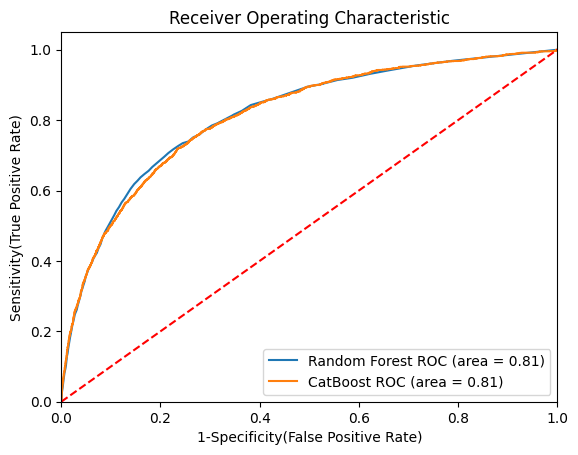

In [117]:
plot_multiplt_rocauc(models,os_data_X_tranformed,os_data_y, df_test_transformed, y_test)

* AUC of all the models are on a similar scale except the XGBoost model which is 0.1 on a higher side

* AUC of XGBoost Light GBM are performing beyeer than the others

* **Key takeaways:**
* **
    * Tree Based model doesn't require scaling of the features
    * Statistical - Logistic Regression requires scaling of the features
    * Upsampling of the Minority Class, Downsampling of the Majority Class and SMOTE sampling results are not better as compared to hyperparamater turning on using class weights in the model itself
    
* ** We will be proceeding with the original dataset without scaling of the featues but using class weights in the model itself**
    

* ** Feature Importance**
    * We will be plotting top features by importance of all the ML algorithms
    * we will be plotting Logistic Regression features by correlation

In [118]:
def plot_feature_importances(model, data):
    plt.figure(figsize=(8,6))
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

Model is  Random Forest
Model is  CatBoost


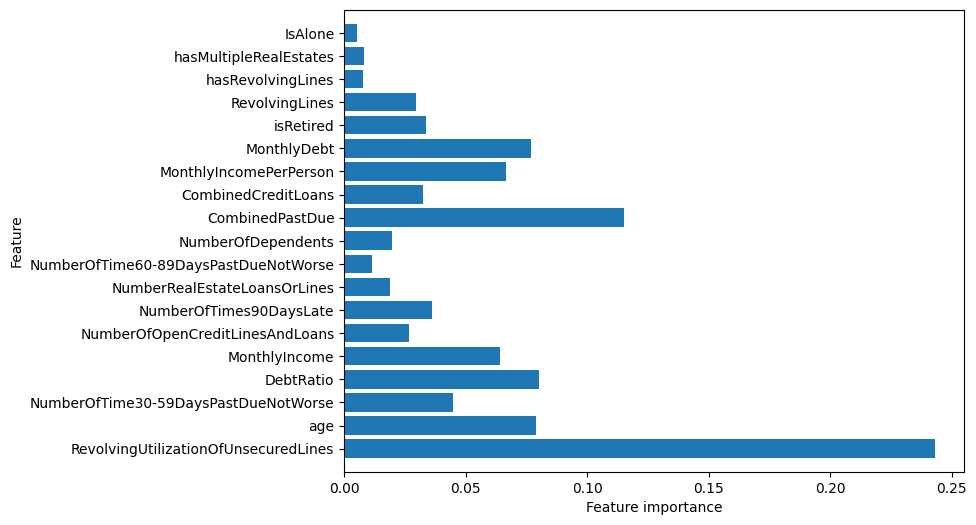

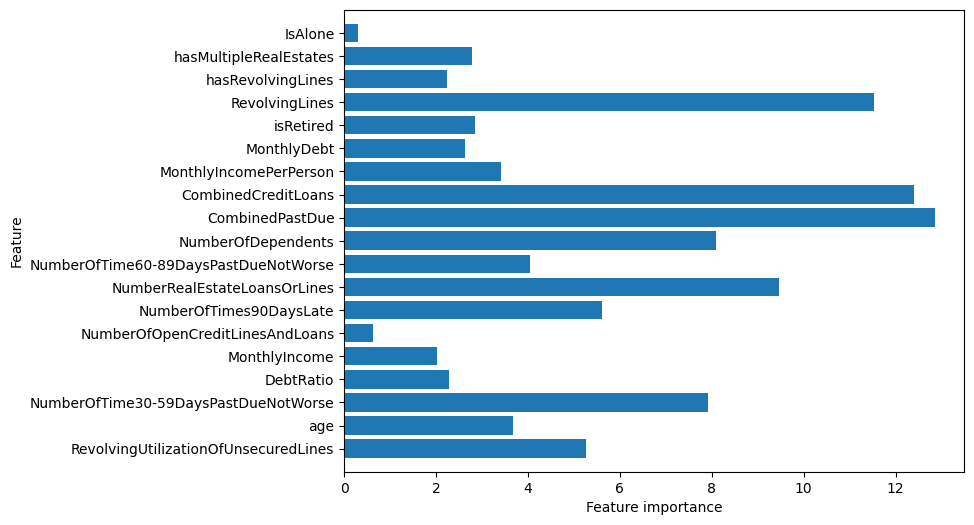

In [119]:
for key in clf_dict.keys():
    if key =='Logistic Regression':
        continue
    else:
        print('Model is ', key)
        plot_feature_importances(clf_dict[key], os_data_X_tranformed)

* In all ML models, ratio of amount owed to the credit limit is the top feature followed by Combined Past Due which is the summation of all dues by a borrower
* **
* In Light GBM model, others features are also contributing to a greater extent

In [142]:
logreg = LogisticRegression(random_state=42)
logreg.fit(os_data_X_tranformed, os_data_y)

coeff_df = pd.DataFrame(os_data_X_tranformed.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Feature  Correlation
0   RevolvingUtilizationOfUnsecuredLines     4.182207
10                       CombinedPastDue     3.012628
11                   CombinedCreditLoans     1.336073
12                MonthlyIncomePerPerson     0.426284
5        NumberOfOpenCreditLinesAndLoans     0.275871
9                     NumberOfDependents     0.248588
13                           MonthlyDebt     0.003340
1                                    age    -0.009563
3                              DebtRatio    -0.019295
7           NumberRealEstateLoansOrLines    -0.232685
4                          MonthlyIncome    -0.451200
17                hasMultipleRealEstates    -0.841009
6                NumberOfTimes90DaysLate    -1.002851
15                        RevolvingLines    -1.093194
18                               IsAlone    -1.188076
8   NumberOfTime60-89DaysPastDueNotWorse    -1.489846
2   NumberOfTime30-59DaysPastDueNotWorse    -1.667136
16                     hasRevolvingLines    -1.806813
14                             isRetired    -2.523409

* Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability)

#### Feature Selection using RFECV

* We will be using RFECV on * **Random Forest** to remove correlated features because they might be providing the same information

In [143]:
def RFE(model, training_data, training_label):
    rfc = model
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    rfecv.fit(training_data, training_label)

    print('Optimal number of features: {}'.format(rfecv.n_features_))
    training_data_rfe = training_data.drop(training_data.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
    plt.show()
    
    dset = pd.DataFrame()
    dset['attr'] = training_data.columns
    dset['importance'] = rfecv.estimator_.feature_importances_

    dset = dset.sort_values(by='importance', ascending=False)


    plt.figure(figsize=(16, 14))
    plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)
    plt.show()
    
    return training_data_rfe.columns.tolist()

In [146]:
rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
rfecv.fit(os_data_X_tranformed, os_data_y)

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 19


In [147]:
rfecv.cv_results_

{'mean_test_score': array([0.7570414 , 0.9232693 , 0.96423153, 0.96644476, 0.96870783,
        0.97406952, 0.97568705]),
 'std_test_score': array([0.00093034, 0.0034413 , 0.00346833, 0.00448167, 0.00433584,
        0.00480389, 0.00486306]),
 'split0_test_score': array([0.75611107, 0.919828  , 0.96076321, 0.96196309, 0.96437199,
        0.96926563, 0.97082399]),
 'split1_test_score': array([0.75797174, 0.9267106 , 0.96769986, 0.97092642, 0.97304366,
        0.97887341, 0.98055011])}

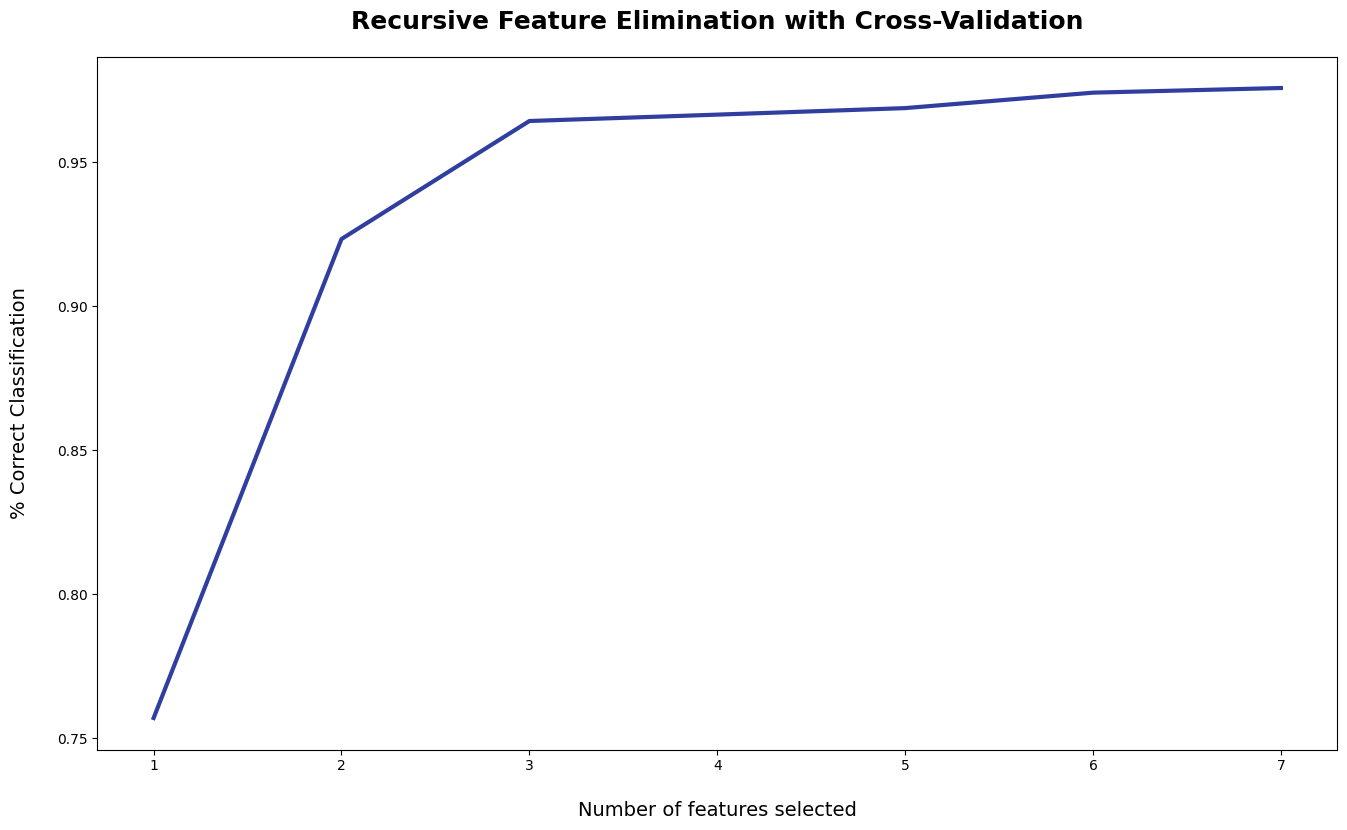

In [148]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)

# rfecv.grid_scores_ has been changed to cv_results_ 
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

plt.show()


In [149]:
print(np.where(rfecv.support_ == False)[0])

os_data_X_tranformed_rfe = os_data_X_tranformed.drop(os_data_X_tranformed.columns[np.where(rfecv.support_ == False)[0]], axis=1)
os_data_X_tranformed_rfe.columns

[]


Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

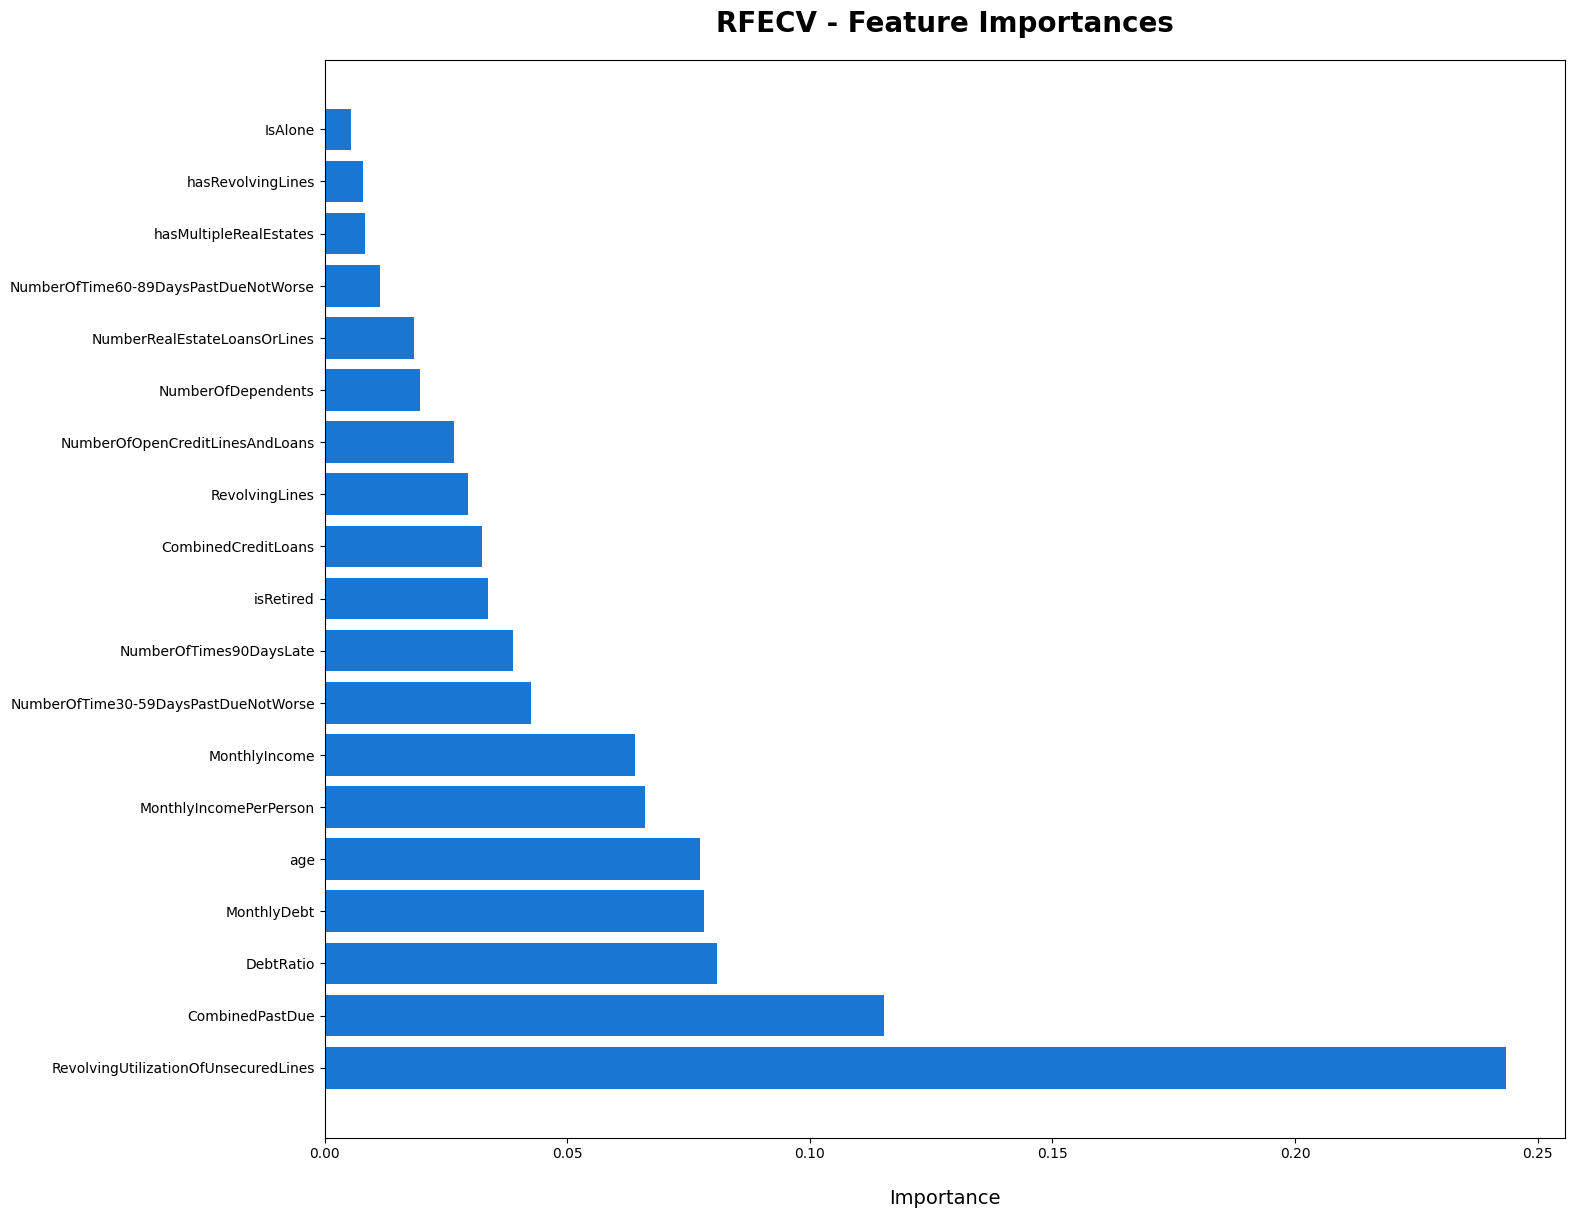

In [150]:
dset = pd.DataFrame()
dset['attr'] = os_data_X_tranformed.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

* Since our optimal performance is with the complete features and no feature is eliminated, we wil be proceeding with the complete Feature Engineered inputs

#### Hypter Paramter Tuning for the Random Forest, XGBoost, and LightGBM
* We will be using GridSearchCV for hyperparamater tuning

* Now we will be using Metrics such as Precision, Recall, F1 Score on class 1 only
* Previously * **macro** and * **micro** were used to give idea how these 2 separate metrics are calculated

In [151]:
def hyperparameter_tuning(classifier, training_dataset, test_dataset, training_label, test_label):
    
    result = []
    cols = [ 'Precision Macro', 'Precision Micro', 'Recall Macro','Recall Micro', 'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']
    
    
    model_name = {}
    class_str = str(classifier)
    if 'Random' in class_str:
        param_grid={
    "n_estimators":[27,36,100,200],
    "max_depth":[5,7,9,15],
    "min_samples_leaf":[2,4,6,8]
        }
        model = GridSearchCV(classifier, param_grid = param_grid, cv=StratifiedKFold(5))
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)

    elif 'XG' in class_str:
        model_name = {}
        parameters = {
    'n_estimators': [100, 200], 
  'max_depth': [3, 5, 8], 
  'gamma' : [0.25,0.5,1],
  'reg_alpha': [0.1, 0.25, 0.5],
  'reg_lambda': [0.5,1,1.15],
  'scale_pos_weight' : [8,10,12,15]
    }
        model = GridSearchCV(classifier, parameters, scoring="neg_log_loss", cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    else:
        model_name = {}
        param_grid = {'n_estimators': [100,250,400],
          'min_split_gain' : [0.25,0.45,0.7],
         'max_depth': [4,7,10],
         'subsample': [0.65,0.85],
         'colsample_bytree': [0.45,0.65,0.85],
         'reg_lambda': [0.5,1,3,5],
         'num_leaves' : [30,50,70],
         'min_data_in_leaf' : [100,400,600]
         }
        
        model = GridSearchCV(estimator = classifier, param_grid = param_grid, 
                          cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm = cal_score(test_label, y_pred)
    result.extend([prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm])
    series_result = pd.Series(data=result, index=cols)   
    
    return series_result, model_name

'def hyperparameter_tuning(classifier, training_dataset, test_dataset, training_label, test_label):\n    \n    result = []\n    cols = [\'Precision\', \'Recall\', \'F1 Score\', \'Confusion Matrix\']\n    \n    model_name = {}\n    class_str = str(classifier)\n    if \'Random\' in class_str:\n        param_grid={\n    "n_estimators":[27,36,100,200],\n    "max_depth":[5,7,9,15],\n    "min_samples_leaf":[2,4,6,8]\n        }\n        model = GridSearchCV(classifier, param_grid = param_grid, cv=StratifiedKFold(5))\n        model.fit(training_dataset, training_label)\n        best_est_model = model.best_estimator_\n        model_name[class_str] = best_est_model\n        best_est_model.fit(training_dataset, training_label)\n        y_pred = best_est_model.predict(test_dataset)\n\n    elif \'XG\' in class_str:\n        model_name = {}\n        parameters = {\n    \'n_estimators\': [100, 200], \n  \'max_depth\': [3, 5, 8], \n  \'gamma\' : [0.25,0.5,1],\n  \'reg_alpha\': [0.1, 0.25, 0.5],\n  \'r

In [159]:
frame_hyperparamater = {} ; model_params = []
for key in clf_dict:
    print(key)
    if key == 'Logistic Regression':
        continue

    hyperparamater_result, model_paramters = hyperparameter_tuning(clf_dict[key], df_train, df_test, y_train, y_test)
    frame_hyperparamater[key]    = hyperparamater_result
    model_params.append(model_paramters)
        
tuned_df = pd.DataFrame(frame_hyperparamater)


Random Forest


In [160]:
model_params

[{'RandomForestClassifier(random_state=42)': RandomForestClassifier(n_estimators=36, random_state=42)}]

In [ ]:
clf_dict_balanced = {'Random Forest': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10}),
           'XGBoost': XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10),
            'Logistic Regression': LogisticRegression(random_state=42, class_weight={0:1,1:10}),
            'Light GBM': LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)}

In [162]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

Random Forest
Mean Accuracy                              0.904
Accuracy deviation                         0.001
Precision Macro                        64.934348
Precision Micro                        89.728177
Recall Macro                           73.108423
Recall Micro                           89.728177
F1 Score Macro                         67.779079
F1 Score Micro                         89.728177
Confusion Matrix    [[25793, 2156], [920, 1077]]

* ** Plotting ROC AUC for the ML models for the original dataset**

In [163]:
models_balanced = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)
    }
]

"models_balanced = [\n    {\n    'label': 'Random Forest',\n    'model': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10})\n    },\n    {\n    'label' : 'XGBoost',\n    'model' : XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10)\n    },\n    {\n    'label' : 'Logistic Regression',\n    'model' : LogisticRegression(random_state=42, class_weight={0:1,1:10})\n    },\n    {\n    'label' : 'Light GBM',\n    'model' : LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)\n    }\n]"

In [164]:
models_balanced = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10})
    }
]

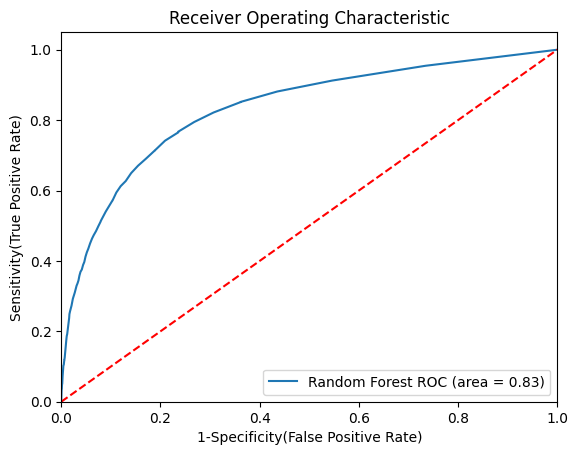

In [165]:
plot_multiplt_rocauc(models,df_train,y_train, df_test, y_test)

* We will be going with the * **Light GBM** model as it is performing better than the other models

In [166]:
model_lgb = LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)

model_lgb.fit(df_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400,
               min_split_gain=0.25, num_leaves=70, random_state=42,
               reg_lambda=5, scale_pos_weight=10, subsample=0.65)

In [170]:
df_train.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

In [171]:
df_test.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone',
       'predictions'],
      dtype='object')

In [167]:
y_pred                 = model_lgb.predict(df_test)
df_test['predictions'] = y_pred

In [168]:
predict_model_lgb = lambda x: model_lgb.predict_proba(x).astype(float)

### Feature Importance and Model Explaination using SHAP and LIME

* ** Why Interpretability in Machine Learning model is needed:**
    * **
    * Fairness - We might be interested in trends of the feature wrt to target variable.
    * Checking causality of features & Debugging models - We might be interested in what pattern among the features model is capturing.
    * Regulations -Sometimes regulatory bodies need answers taken on model inference

* Explaining the model performance using SHAP so that black box model can become transparent one.
* **We will be looking at the model transparency using SHAP at global level and LIME at a local level**
* **
* The collective SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target .
    

* **SHAP(SHapely Additive exPlainations)**

#### Variable Importance Plot — Global Interpretability

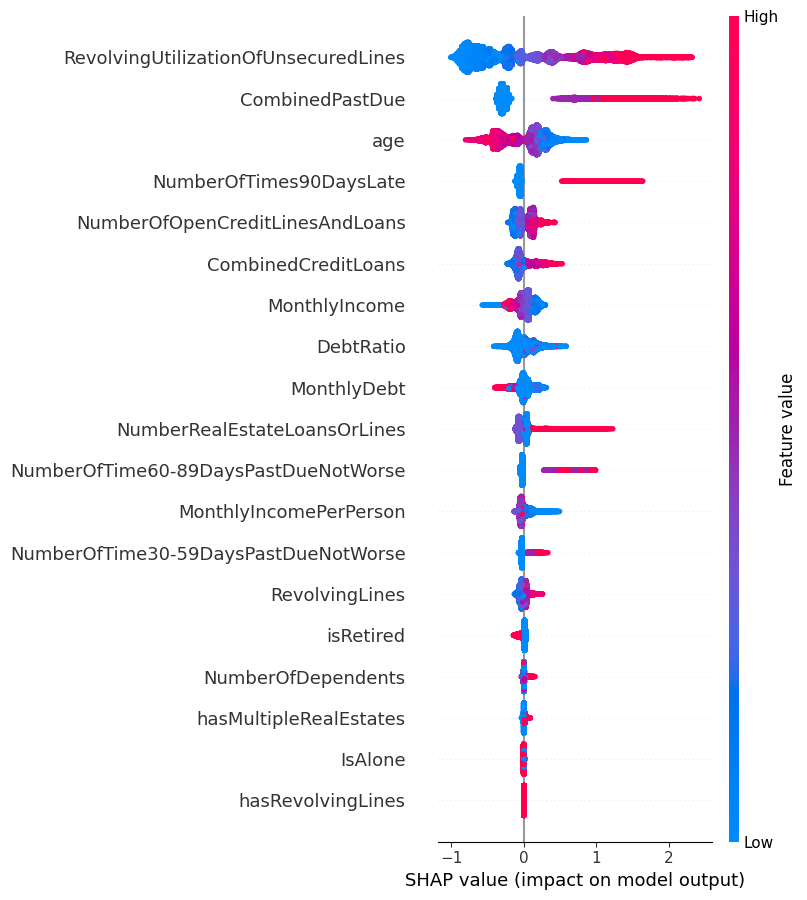

In [173]:
X_importance = df_test.drop('predictions', axis=1)

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance)

* Feature importance: Variables are ranked in descending order.
* **
* Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* **
* Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
* **
* Correlation: A high level of the “RevolvingUtilizationOfUnsecuredLines” and "Debt Ratio" has a high and positive impact on the defaulting. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “age” is equally correlated with the target variable and non-target variable which might not give any good performance.
* "Monthly Income" effect is comparitvely low toward prediting values and even the effect is alos low

#### SHAP Dependence Plot — Global Interpretability

* The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex. 
* The function automatically includes another variable that your chosen variable interacts most with.

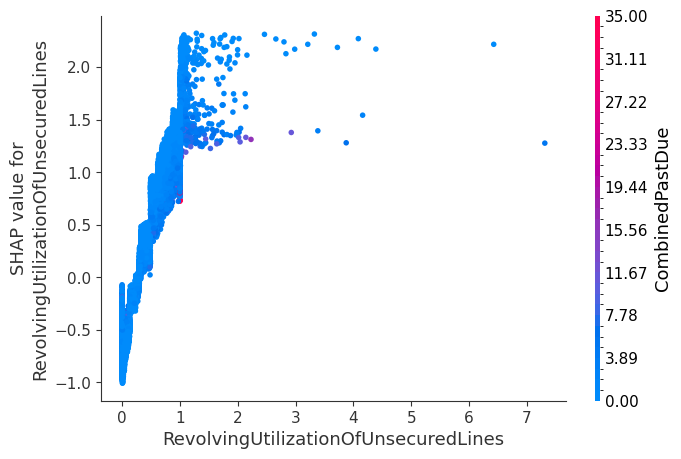

In [174]:
shap.dependence_plot("RevolvingUtilizationOfUnsecuredLines", shap_values[1], X_importance)

* The following plot shows there is an very little linear and a bit of positive trend between “RevolvingUtilizationOfUnsecuredLines” and the target variable, and “RevolvingUtilizationOfUnsecuredLines” does not interact with “CombinedPastDue”.

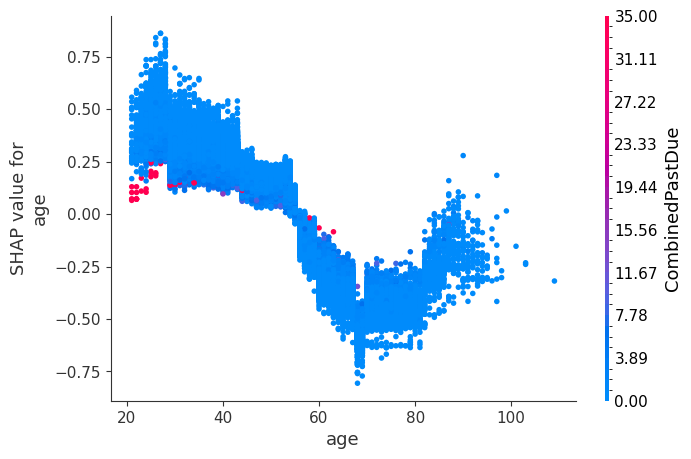

In [175]:
shap.dependence_plot("age", shap_values[1], X_importance)

* The following plot shows there is an good linear and a negative trend between “age” and the target variable, and “age” interacts with “CombinedPastDue” not so much.

#### LIME(Local Interpretable Model agnostic Explanations)

* ** If we want to understand how a single prediction was made for a given observation. This is where we use the LIME technique which stands for local interpretable model agnostic explanations.**

* Generating explainations using LIME

In [178]:
# creating the explainer function
df_test = df_test.drop('predictions', axis=1)
explainer = LimeTabularExplainer(df_test.values, mode="classification", feature_names=df_test.columns)

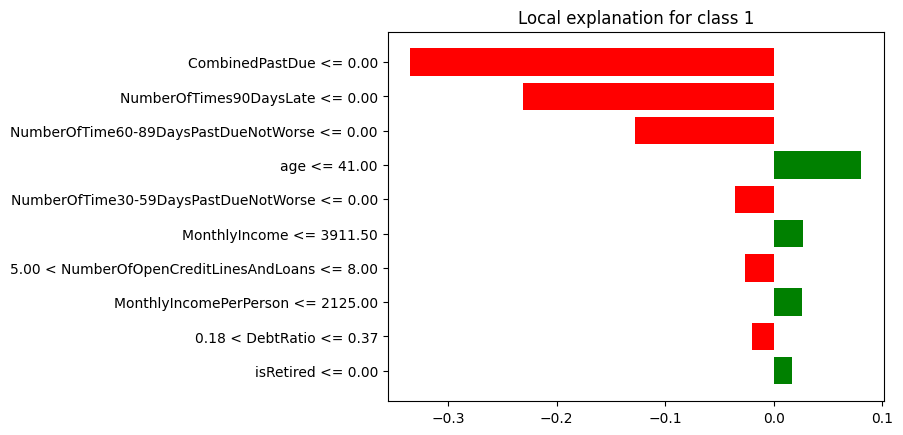

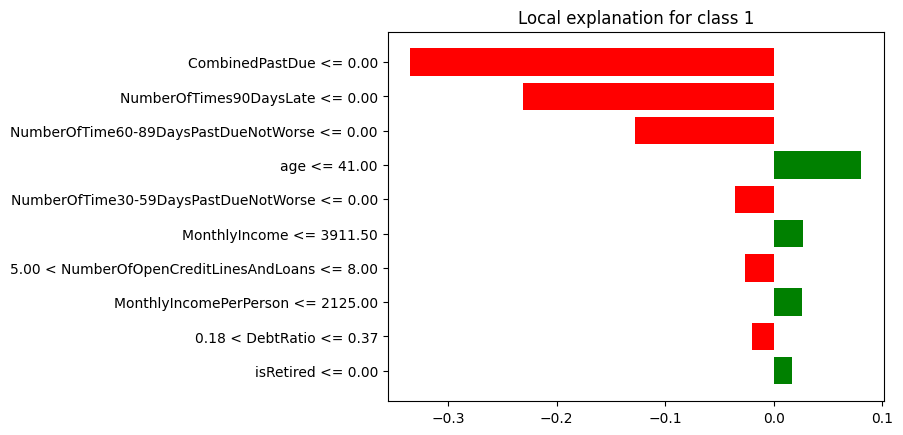

In [179]:
exp = explainer.explain_instance(df_test.iloc[3], 
     predict_model_lgb, num_features=10)
exp.as_pyplot_figure()

* Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.
* No of times 30-59, 59-90 days and 90 days past due having no values means not missed any due date showing veryr high negative correlation with the target
* age having less values lower than 41 relatively show positive corrrelation with the target

In [180]:
# storing a new observation
i = 37
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)
        

0.7765225277865052


* Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on defaulting for this row.

In [181]:
# storing a new observation
i = 37
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)
        

0.42249794036802535


### conclusion

* Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on non delinquency for this row which has value 0 and Monthly Income feature having value greater than 73000 contributing towards non delinquency.